In [43]:
import yfinance as yf
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import warnings

warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Prepare Dataset

In [44]:
# Data Download Configuration
# S&P 500: January 1, 2002 to December 31, 2023
# Bitcoin: January 1, 2015 to December 31, 2023

# Define date ranges
sp500_start = "2002-01-01"
sp500_end = "2023-12-31"
bitcoin_start = "2015-01-01"
bitcoin_end = "2023-12-31"

print("Downloading S&P 500 data...")
# Download S&P 500 data (^GSPC is the Yahoo Finance ticker)
sp500_data = yf.download("^GSPC", start=sp500_start, end=sp500_end, progress=False)

print("Downloading Bitcoin data...")
# Download Bitcoin data (BTC-USD is the Yahoo Finance ticker)
bitcoin_data = yf.download("BTC-USD", start=bitcoin_start, end=bitcoin_end, progress=False)

# Display basic information about downloaded data
print(f"\nS&P 500 Data Shape: {sp500_data.shape}")
print(f"S&P 500 Date Range: {sp500_data.index.min()} to {sp500_data.index.max()}")
print(f"Total S&P 500 observations: {len(sp500_data)}")

print(f"\nBitcoin Data Shape: {bitcoin_data.shape}")
print(f"Bitcoin Date Range: {bitcoin_data.index.min()} to {bitcoin_data.index.max()}")
print(f"Total Bitcoin observations: {len(bitcoin_data)}")

sp500_data.columns = sp500_data.columns.set_levels(['Adj Close' if x == 'Close' else x for x in sp500_data.columns.levels[0]], level=0)

bitcoin_data.columns = bitcoin_data.columns.set_levels(['Adj Close' if x == 'Close' else x for x in bitcoin_data.columns.levels[0]], level=0)


print("\nVerification - S&P 500 has Adj Close:", ('Adj Close', '^GSPC') in sp500_data.columns)
print("Verification - Bitcoin has Adj Close:", ('Adj Close', 'BTC-USD') in bitcoin_data.columns)


S&P 500 Data Shape: (5537, 5)
S&P 500 Date Range: 2002-01-02 00:00:00 to 2023-12-29 00:00:00
Total S&P 500 observations: 5537

Bitcoin Data Shape: (3286, 5)
Bitcoin Date Range: 2015-01-01 00:00:00 to 2023-12-30 00:00:00
Total Bitcoin observations: 3286

Verification - S&P 500 has Adj Close: True
Verification - Bitcoin has Adj Close: True


In [45]:
sp500_data['Log_Returns'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1))

bitcoin_data['Log_Returns'] = np.log(bitcoin_data['Adj Close'] / bitcoin_data['Adj Close'].shift(1))

sp500_clean = sp500_data.dropna()
bitcoin_clean = bitcoin_data.dropna()


In [46]:
statistics_data = {
    'Observations': [len(sp500_clean), len(bitcoin_clean)],
    'Mean_Daily_Return': [sp500_clean['Log_Returns'].mean(), bitcoin_clean['Log_Returns'].mean()],
    'Standard_Deviation': [sp500_clean['Log_Returns'].std(), bitcoin_clean['Log_Returns'].std()],
    'Minimum_Return': [sp500_clean['Log_Returns'].min(), bitcoin_clean['Log_Returns'].min()],
    'Maximum_Return': [sp500_clean['Log_Returns'].max(), bitcoin_clean['Log_Returns'].max()],
    'Skewness': [sp500_clean['Log_Returns'].skew(), bitcoin_clean['Log_Returns'].skew()],
    'Kurtosis': [sp500_clean['Log_Returns'].kurtosis(), bitcoin_clean['Log_Returns'].kurtosis()],
    'Infinite_Values': [np.isinf(sp500_clean['Log_Returns']).sum(), np.isinf(bitcoin_clean['Log_Returns']).sum()],
    'NaN_Values': [sp500_clean['Log_Returns'].isnull().sum(), bitcoin_clean['Log_Returns'].isnull().sum()]
}

# Create DataFrame with asset names as index
returns_statistics = pd.DataFrame(statistics_data, index=['S&P_500', 'Bitcoin'])

returns_statistics.T


,S&P_500,Bitcoin
Observations,5536.000000,3285.000000
Mean_Daily_Return,0.000256,0.001491
Standard_Deviation,0.012245,0.037394
Minimum_Return,-0.127652,-0.464730
Maximum_Return,0.109572,0.225119
Skewness,-0.423037,-0.793774
Kurtosis,11.499578,11.618614
Infinite_Values,0.000000,0.000000
NaN_Values,0.000000,0.000000


=== FINAL DATA VERIFICATION ===



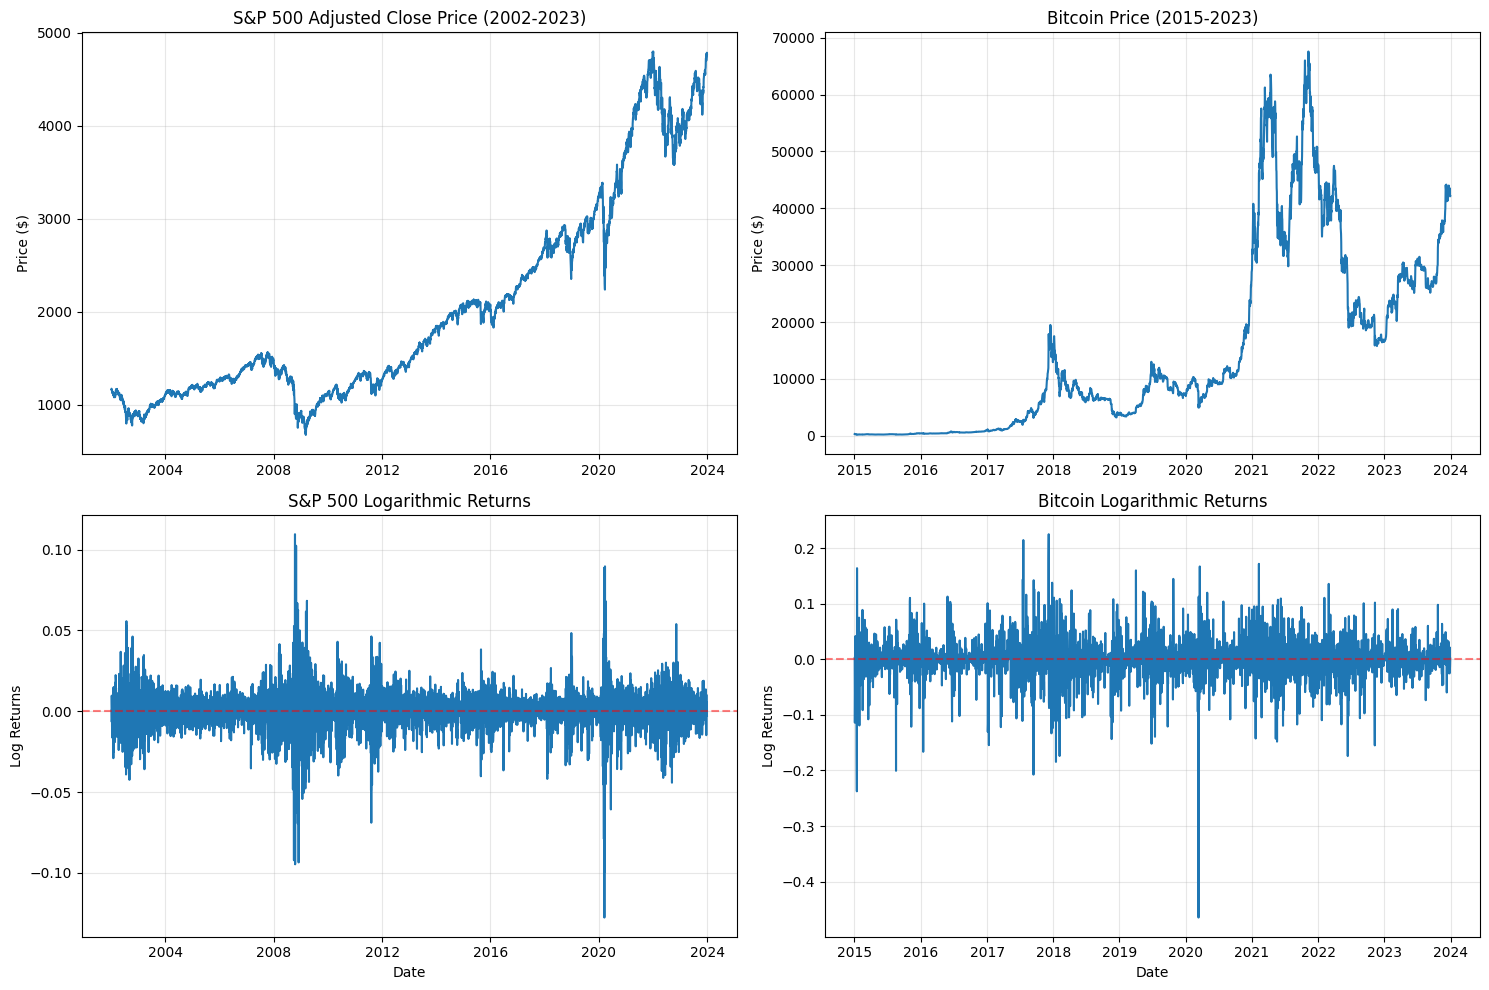


=== SAMPLE DATA PREVIEW ===

S&P 500 Data (First 5 rows):
Price              Open         High          Low    Adj Close      Volume Log_Returns
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC            
Date                                                                                  
2002-01-03  1154.670044  1165.270020  1154.010010  1165.270020  1398900000    0.009138
2002-01-04  1165.270020  1176.550049  1163.420044  1172.510010  1513000000    0.006194
2002-01-07  1172.510010  1176.969971  1163.550049  1164.890015  1308300000   -0.006520
2002-01-08  1164.890015  1167.599976  1157.459961  1160.709961  1258800000   -0.003595
2002-01-09  1160.709961  1174.260010  1151.890015  1155.140015  1452000000   -0.004810

Bitcoin Data (First 5 rows):
Price             Open        High         Low   Adj Close    Volume Log_Returns
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD            
Date                                                 

In [47]:
# Data Visualization and Final Verification

print("=== FINAL DATA VERIFICATION ===\n")

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# S&P 500 Price Series
ax1.plot(sp500_clean.index, sp500_clean['Adj Close'])
ax1.set_title('S&P 500 Adjusted Close Price (2002-2023)')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# Bitcoin Price Series
ax2.plot(bitcoin_clean.index, bitcoin_clean['Adj Close'])
ax2.set_title('Bitcoin Price (2015-2023)')
ax2.set_ylabel('Price ($)')
ax2.grid(True, alpha=0.3)

# S&P 500 Log Returns
ax3.plot(sp500_clean.index, sp500_clean['Log_Returns'])
ax3.set_title('S&P 500 Logarithmic Returns')
ax3.set_ylabel('Log Returns')
ax3.set_xlabel('Date')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

# Bitcoin Log Returns
ax4.plot(bitcoin_clean.index, bitcoin_clean['Log_Returns'])
ax4.set_title('Bitcoin Logarithmic Returns')
ax4.set_ylabel('Log Returns')
ax4.set_xlabel('Date')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display sample data
print("\n=== SAMPLE DATA PREVIEW ===\n")
print("S&P 500 Data (First 5 rows):")
print(sp500_clean[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Log_Returns']].head())

print("\nBitcoin Data (First 5 rows):")
print(bitcoin_clean[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Log_Returns']].head())



Stationary Test

ADF Statistic: -18.553729
p-value: 0.000000


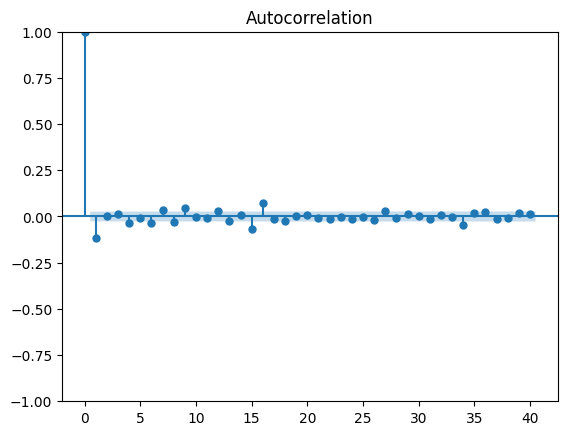

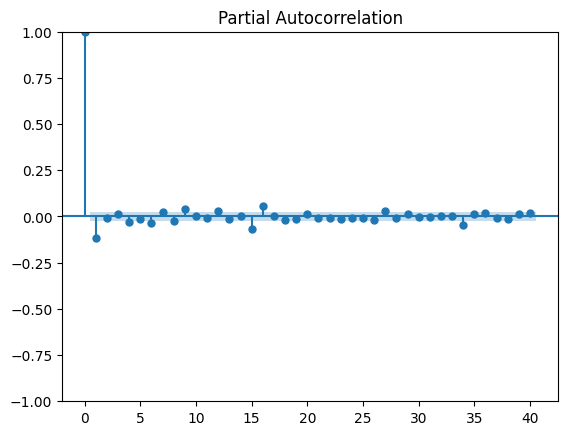

In [48]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


sp500_adf_test = adfuller(sp500_clean['Log_Returns'])
# Output the results
print('ADF Statistic: %f' % sp500_adf_test[0])
print('p-value: %f' % sp500_adf_test[1])

plot_acf(sp500_clean['Log_Returns'], lags=40)
plot_pacf(sp500_clean['Log_Returns'], lags=40)
plt.show()

ADF Statistic: -58.553594
p-value: 0.000000


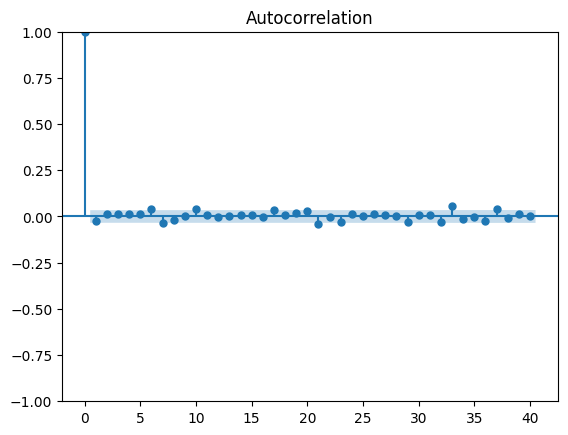

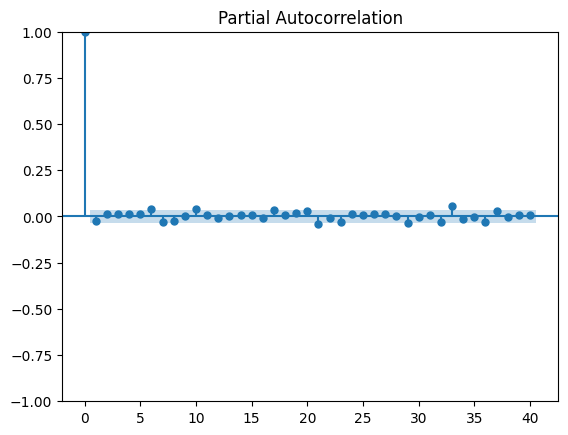

In [49]:
bitcoin_adf_test = adfuller(bitcoin_clean['Log_Returns'])
# Output the results
print('ADF Statistic: %f' % bitcoin_adf_test[0])
print('p-value: %f' % bitcoin_adf_test[1])

plot_acf(bitcoin_clean['Log_Returns'], lags=40)
plot_pacf(bitcoin_clean['Log_Returns'], lags=40)
plt.show()

# Cross Validation

In [50]:
# Time Series Cross-Validation Implementation
# Novel 3-fold cross-validation scheme with rolling windows

import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# print("=== TIME SERIES CROSS-VALIDATION IMPLEMENTATION ===\n")

def create_sp500_cv_splits(data, start_date=None):
    """
    Create S&P 500 cross-validation splits:
    - 6-year windows (3yr train + 2yr validation + 1yr test)  
    - Validation split into 8, 16, 24 months
    - Window moves 1 year forward each iteration
    """
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=3) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1) # 16 months  
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1) # 24 months (2 years)
        
        # Test period (1 year)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(years=1) - timedelta(days=1)
        
        # Check if we have enough data
        # if test_end > data.index.max():
        if test_end.year > 2024:
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2, 
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

def create_bitcoin_cv_splits(data, start_date=None):
    """
    Create Bitcoin cross-validation splits:
    - 2-year training + validation periods + 6-month test
    - Validation periods: 4, 8, 12 months
    - Window shifts forward by 6 months each iteration  
    - Testing period: 2018-01-01 to 2023-12-31
    """
    
    if start_date is None:
        # Start from a date that allows for proper window construction
        start_date = datetime(2015, 1, 1)
    
    cv_splits = []
    window_start = start_date
    
    # Define the testing period constraint
    test_period_start = datetime(2018, 1, 1)
    test_period_end = datetime(2023, 12, 31)
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (4, 8, 12 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=4) - timedelta(days=1)  # 4 months
        val2_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val3_end = val_start + relativedelta(months=12) - timedelta(days=1) # 12 months
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check constraints
        # if test_end > data.index.max() or test_end > test_period_end:
        #     break
        if test_end.year > 2023:
            break
        
        # Only include windows where test period is within 2018-2023
        if test_start < test_period_start:
            window_start += relativedelta(months=6)
            continue
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 4
                },
                {
                    'fold': 2,
                    'data': val2_data, 
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 8
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 12
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 6 months
        window_start += relativedelta(months=6)
    
    return cv_splits



In [51]:
# Apply Cross-Validation Schemes to Data

print("=== GENERATING CROSS-VALIDATION SPLITS ===\n")

# Generate S&P 500 cross-validation splits
sp500_cv_splits = create_sp500_cv_splits(sp500_clean)


# Generate Bitcoin cross-validation splits  
bitcoin_cv_splits = create_bitcoin_cv_splits(bitcoin_clean)


# Create summary DataFrames
def create_cv_summary(cv_splits, asset_name):
    """Create a summary DataFrame for cross-validation splits"""
    summary_data = []
    
    for split in cv_splits:
        # Add training data info
        summary_data.append({
            'Asset': asset_name,
            'Window_ID': split['window_id'],
            'Split_Type': 'Train',
            'Fold': 'N/A',
            'Start_Date': split['train']['start'].strftime('%Y-%m-%d'),
            'End_Date': split['train']['end'].strftime('%Y-%m-%d'),
            'Size': split['train']['size'],
            'Duration_Months': 'N/A'
        })
        
        # Add validation data info
        for val_fold in split['validation']:
            summary_data.append({
                'Asset': asset_name,
                'Window_ID': split['window_id'],
                'Split_Type': 'Validation',
                'Fold': val_fold['fold'],
                'Start_Date': val_fold['start'].strftime('%Y-%m-%d'),
                'End_Date': val_fold['end'].strftime('%Y-%m-%d'),
                'Size': val_fold['size'],
                'Duration_Months': val_fold['months']
            })
        
        # Add test data info
        summary_data.append({
            'Asset': asset_name,
            'Window_ID': split['window_id'],
            'Split_Type': 'Test',
            'Fold': 'N/A',
            'Start_Date': split['test']['start'].strftime('%Y-%m-%d'),
            'End_Date': split['test']['end'].strftime('%Y-%m-%d'),
            'Size': split['test']['size'],
            'Duration_Months': 'N/A'
        })
    
    return pd.DataFrame(summary_data)

# Create summary DataFrames
sp500_cv_summary = create_cv_summary(sp500_cv_splits, 'S&P_500')
bitcoin_cv_summary = create_cv_summary(bitcoin_cv_splits, 'Bitcoin')

# Combined summary
cv_summary_combined = pd.concat([sp500_cv_summary, bitcoin_cv_summary], ignore_index=True)

# print("\n=== CROSS-VALIDATION SUMMARY ===")
# print(f"S&P 500 total windows: {len(sp500_cv_splits)}")
# print(f"Bitcoin total windows: {len(bitcoin_cv_splits)}")
# print(f"Total CV splits created: {len(cv_summary_combined)}")

# Display first few windows for each asset
print("\n=== S&P 500 CV WINDOWS (First set) ===")
for i, split in enumerate(sp500_cv_splits[:1]):
    print(f"\nWindow {split['window_id']}:")
    print(f"  Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
    print(f"  Validation Folds:")
    for val_fold in split['validation']:
        print(f"    Fold {val_fold['fold']} ({val_fold['months']}mo): {val_fold['start'].strftime('%Y-%m-%d')} to {val_fold['end'].strftime('%Y-%m-%d')} ({val_fold['size']} obs)")
    print(f"  Test: {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")

print("\n=== BITCOIN CV WINDOWS (First set) ===")
for i, split in enumerate(bitcoin_cv_splits[:1]):
    print(f"\nWindow {split['window_id']}:")
    print(f"  Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
    print(f"  Validation Folds:")
    for val_fold in split['validation']:
        print(f"    Fold {val_fold['fold']} ({val_fold['months']}mo): {val_fold['start'].strftime('%Y-%m-%d')} to {val_fold['end'].strftime('%Y-%m-%d')} ({val_fold['size']} obs)")
    print(f"  Test: {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")

# Display summary statistics
print("\n=== CV SPLIT STATISTICS ===")
split_stats = cv_summary_combined.groupby(['Asset', 'Split_Type']).agg({
    'Size': ['mean', 'std', 'min', 'max'],
    'Window_ID': 'count'
}).round(0)
print(split_stats)


=== GENERATING CROSS-VALIDATION SPLITS ===


=== S&P 500 CV WINDOWS (First set) ===

Window 1:
  Train: 2002-01-03 to 2005-01-02 (755 obs)
  Validation Folds:
    Fold 1 (8mo): 2005-01-03 to 2005-09-02 (170 obs)
    Fold 2 (16mo): 2005-01-03 to 2006-05-02 (335 obs)
    Fold 3 (24mo): 2005-01-03 to 2007-01-02 (503 obs)
  Test: 2007-01-03 to 2008-01-02 (252 obs)

=== BITCOIN CV WINDOWS (First set) ===

Window 1:
  Train: 2015-01-01 to 2016-12-31 (730 obs)
  Validation Folds:
    Fold 1 (4mo): 2017-01-01 to 2017-04-30 (120 obs)
    Fold 2 (8mo): 2017-01-01 to 2017-08-31 (243 obs)
    Fold 3 (12mo): 2017-01-01 to 2017-12-31 (365 obs)
  Test: 2018-01-01 to 2018-06-30 (181 obs)

=== CV SPLIT STATISTICS ===
                     Size                  Window_ID
                     mean    std  min  max     count
Asset   Split_Type                                  
Bitcoin Test        182.0    1.0  181  184        12
        Train       730.0    1.0  730  731        12
        Validation  243.0

In [52]:
# Visualize Cross-Validation Scheme

def plot_cv_timeline(cv_splits, asset_name, max_windows=8):
    """Create a timeline visualization of the cross-validation scheme"""
    
    fig, ax = plt.subplots(figsize=(16, max(6, len(cv_splits[:max_windows]) * 1.5)))
    
    # Colors for different split types
    colors = {
        'train': '#2E8B57',      # Sea Green
        'val_fold1': '#4169E1',  # Royal Blue
        'val_fold2': '#1E90FF',  # Dodger Blue  
        'val_fold3': '#87CEEB',  # Sky Blue
        'test': '#DC143C'        # Crimson
    }
    
    y_positions = []
    
    for i, split in enumerate(cv_splits[:max_windows]):
        y_pos = len(cv_splits[:max_windows]) - i - 1
        y_positions.append(y_pos)
        
        # Plot training period
        ax.barh(y_pos, (split['train']['end'] - split['train']['start']).days, 
                left=split['train']['start'], height=0.6, 
                color=colors['train'], alpha=0.8, label='Train' if i == 0 else "")
        
        # Plot validation periods
        val_colors = ['val_fold1', 'val_fold2', 'val_fold3']
        for j, val_fold in enumerate(split['validation']):
            ax.barh(y_pos + 0.1 + j*0.15, (val_fold['end'] - val_fold['start']).days,
                    left=val_fold['start'], height=0.12,
                    color=colors[val_colors[j]], alpha=0.8,
                    label=f'Val Fold {j+1} ({val_fold["months"]}mo)' if i == 0 else "")
        
        # Plot test period
        ax.barh(y_pos, (split['test']['end'] - split['test']['start']).days,
                left=split['test']['start'], height=0.6,
                color=colors['test'], alpha=0.8, label='Test' if i == 0 else "")
        
        # Add window labels
        ax.text(split['train']['start'], y_pos, f'W{split["window_id"]}',
                verticalalignment='center', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.set_ylim(-0.5, len(cv_splits[:max_windows]) - 0.5)
    ax.set_ylabel('CV Windows (Newest to Oldest)', fontsize=12)
    ax.set_xlabel('Time Period', fontsize=12)
    ax.set_title(f'{asset_name} Cross-Validation Timeline\n({len(cv_splits)} Total Windows, Showing First {min(max_windows, len(cv_splits))})', 
                fontsize=14, fontweight='bold')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True, fancybox=True, shadow=True)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig, ax

print("=== CROSS-VALIDATION SCHEME VISUALIZATION ===\n")

# Create visualizations
# fig1, ax1 = plot_cv_timeline(sp500_cv_splits, 'S&P 500', max_windows=8)
# plt.show()

# fig2, ax2 = plot_cv_timeline(bitcoin_cv_splits, 'Bitcoin', max_windows=8)  
# plt.show()

# Create a comprehensive comparison chart
def create_cv_comparison_chart():
    """Create a side-by-side comparison of CV schemes"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # S&P 500 scheme visualization
    y_pos = 1
    
    # S&P 500 scheme
    ax1.barh(y_pos, 3*365, left=0, height=0.6, color='#2E8B57', alpha=0.8, label='Train (3yr)')
    ax1.barh(y_pos+0.1, 8*30, left=3*365, height=0.15, color='#4169E1', alpha=0.8, label='Val Fold 1 (8mo)')
    ax1.barh(y_pos+0.25, 16*30, left=3*365, height=0.15, color='#1E90FF', alpha=0.8, label='Val Fold 2 (16mo)')
    ax1.barh(y_pos+0.4, 24*30, left=3*365, height=0.15, color='#87CEEB', alpha=0.8, label='Val Fold 3 (24mo)')
    ax1.barh(y_pos, 1*365, left=5*365, height=0.6, color='#DC143C', alpha=0.8, label='Test (1yr)')
    
    ax1.set_xlim(0, 6*365)
    ax1.set_ylim(0.5, 1.8)
    ax1.set_xlabel('Days')
    ax1.set_title('S&P 500 CV Scheme\n(6-year windows)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bitcoin scheme
    ax2.barh(y_pos, 2*365, left=0, height=0.6, color='#2E8B57', alpha=0.8, label='Train (2yr)')
    ax2.barh(y_pos+0.1, 4*30, left=2*365, height=0.15, color='#4169E1', alpha=0.8, label='Val Fold 1 (4mo)')
    ax2.barh(y_pos+0.25, 8*30, left=2*365, height=0.15, color='#1E90FF', alpha=0.8, label='Val Fold 2 (8mo)')
    ax2.barh(y_pos+0.4, 12*30, left=2*365, height=0.15, color='#87CEEB', alpha=0.8, label='Val Fold 3 (12mo)')
    ax2.barh(y_pos, 6*30, left=3*365, height=0.6, color='#DC143C', alpha=0.8, label='Test (6mo)')
    
    ax2.set_xlim(0, 3.5*365)
    ax2.set_ylim(0.5, 1.8)
    ax2.set_xlabel('Days')
    ax2.set_title('Bitcoin CV Scheme\n(~3.5-year windows)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Time Series Cross-Validation Scheme Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# fig3 = create_cv_comparison_chart()
# plt.show()

# Create summary table
cv_scheme_summary = pd.DataFrame({
    'Asset': ['S&P 500', 'Bitcoin'],
    'Total_Windows': [len(sp500_cv_splits), len(bitcoin_cv_splits)],
    'Window_Length': ['6 years', '~3.5 years'],
    'Train_Period': ['3 years', '2 years'],
    'Validation_Folds': ['8/16/24 months', '4/8/12 months'],
    'Test_Period': ['1 year', '6 months'],
    'Window_Shift': ['1 year', '6 months'],
    'Test_Coverage': [
        f"{sp500_cv_splits[0]['test']['start'].strftime('%Y-%m-%d')} to {sp500_cv_splits[-1]['test']['end'].strftime('%Y-%m-%d')}",
        f"{bitcoin_cv_splits[0]['test']['start'].strftime('%Y-%m-%d')} to {bitcoin_cv_splits[-1]['test']['end'].strftime('%Y-%m-%d')}"
    ]
})

# print("\n=== CROSS-VALIDATION SCHEME SUMMARY ===")
# print(cv_scheme_summary.to_string(index=False))

# print(f"\n✓ Cross-validation visualization complete!")
# print(f"✓ Total S&P 500 windows: {len(sp500_cv_splits)}")
# print(f"✓ Total Bitcoin windows: {len(bitcoin_cv_splits)}")
# print(f"✓ Robust 3-fold validation implemented for both assets")


=== CROSS-VALIDATION SCHEME VISUALIZATION ===



In [53]:
# Utility Functions for Cross-Validation Data Access

def get_cv_data(cv_splits, window_id, fold=None, return_type='data'):
    """
    Utility function to easily access cross-validation data
    
    Parameters:
    - cv_splits: List of CV splits (sp500_cv_splits or bitcoin_cv_splits)
    - window_id: Window ID (1, 2, 3, etc.)
    - fold: Validation fold (1, 2, 3) or None for train/test
    - return_type: 'train', 'validation', 'test', or 'data' (returns the data)
    
    Returns:
    - DataFrame with the requested data split
    """
    
    split = next((s for s in cv_splits if s['window_id'] == window_id), None)
    if split is None:
        raise ValueError(f"Window ID {window_id} not found")
    
    if return_type == 'train':
        return split['train']['data']
    elif return_type == 'test':
        return split['test']['data']
    elif return_type == 'validation':
        if fold is None:
            raise ValueError("Fold number must be specified for validation data")
        if fold not in [1, 2, 3]:
            raise ValueError("Fold must be 1, 2, or 3")
        return split['validation'][fold-1]['data']
    else:
        return split

# Example usage functions
def demonstrate_cv_usage():
    """Demonstrate how to use the cross-validation splits"""
    
    print("=== CROSS-VALIDATION DATA ACCESS EXAMPLES ===\n")
    
    # Example 1: Get training data from first S&P 500 window
    train_data_sp500 = get_cv_data(sp500_cv_splits, window_id=1, return_type='train')
    print(f"S&P 500 Window 1 - Training data shape: {train_data_sp500.shape}")
    print(f"Training period: {train_data_sp500.index.min()} to {train_data_sp500.index.max()}")
    
    # Example 2: Get validation fold 2 data from first S&P 500 window  
    val_data_sp500 = get_cv_data(sp500_cv_splits, window_id=1, fold=2, return_type='validation')
    print(f"\nS&P 500 Window 1 - Validation Fold 2 shape: {val_data_sp500.shape}")
    print(f"Validation period: {val_data_sp500.index.min()} to {val_data_sp500.index.max()}")
    
    # Example 3: Get test data from first Bitcoin window
    test_data_bitcoin = get_cv_data(bitcoin_cv_splits, window_id=1, return_type='test')
    print(f"\nBitcoin Window 1 - Test data shape: {test_data_bitcoin.shape}")
    print(f"Test period: {test_data_bitcoin.index.min()} to {test_data_bitcoin.index.max()}")
    
    return train_data_sp500, val_data_sp500, test_data_bitcoin

# Run demonstration
sample_train, sample_val, sample_test = demonstrate_cv_usage()

# Create final summary for the implementation
print("\n" + "="*80)
print("TIME SERIES CROSS-VALIDATION IMPLEMENTATION COMPLETE")
print("="*80)

print(f"""
✓ IMPLEMENTATION SUMMARY:

📊 S&P 500 Cross-Validation Scheme:
   • {len(sp500_cv_splits)} rolling windows of 6 years each
   • Training: 3 years | Validation: 2 years (3 folds) | Test: 1 year
   • Validation folds: 8, 16, and 24 months
   • Window advancement: 1 year forward

📈 Bitcoin Cross-Validation Scheme:
   • {len(bitcoin_cv_splits)} rolling windows of ~3.5 years each  
   • Training: 2 years | Validation: 1 year (3 folds) | Test: 6 months
   • Validation folds: 4, 8, and 12 months
   • Window advancement: 6 months forward
   • Test period constraint: 2018-2023

🔧 Key Features:
   • Prevents data leakage through temporal ordering
   • Robust hyperparameter selection via 3-fold validation
   • Adapts to changing market conditions
   • Novel variation of Choi et al. (2024) approach
   • Comprehensive visualization and data access utilities

📈 Ready for Model Training:
   • Use get_cv_data() function to access splits
   • All data properly formatted with logarithmic returns
   • Timeline visualizations available for paper figures
""")

print("🚀 Your sophisticated time series cross-validation is now ready for machine learning model training!")

# Save CV splits for later use (optional)
cv_implementation_summary = {
    'sp500_cv_splits': sp500_cv_splits,
    'bitcoin_cv_splits': bitcoin_cv_splits,
    'sp500_summary': sp500_cv_summary,
    'bitcoin_summary': bitcoin_cv_summary,
    'combined_summary': cv_summary_combined,
    'scheme_comparison': cv_scheme_summary
}

print(f"\n✓ All cross-validation data structures saved and ready for use!")
print(f"✓ Access data using: get_cv_data(sp500_cv_splits, window_id=1, return_type='train')")
print(f"✓ {len(sp500_cv_splits) + len(bitcoin_cv_splits)} total windows created across both assets")


=== CROSS-VALIDATION DATA ACCESS EXAMPLES ===

S&P 500 Window 1 - Training data shape: (755, 6)
Training period: 2002-01-03 00:00:00 to 2004-12-31 00:00:00

S&P 500 Window 1 - Validation Fold 2 shape: (335, 6)
Validation period: 2005-01-03 00:00:00 to 2006-05-02 00:00:00

Bitcoin Window 1 - Test data shape: (181, 6)
Test period: 2018-01-01 00:00:00 to 2018-06-30 00:00:00

TIME SERIES CROSS-VALIDATION IMPLEMENTATION COMPLETE

✓ IMPLEMENTATION SUMMARY:

📊 S&P 500 Cross-Validation Scheme:
   • 17 rolling windows of 6 years each
   • Training: 3 years | Validation: 2 years (3 folds) | Test: 1 year
   • Validation folds: 8, 16, and 24 months
   • Window advancement: 1 year forward

📈 Bitcoin Cross-Validation Scheme:
   • 12 rolling windows of ~3.5 years each  
   • Training: 2 years | Validation: 1 year (3 folds) | Test: 6 months
   • Validation folds: 4, 8, and 12 months
   • Window advancement: 6 months forward
   • Test period constraint: 2018-2023

🔧 Key Features:
   • Prevents data lea

# TRY ARIMA + LSTM HYBRID

## ARIMA

In [54]:
# ARIMA Model Implementation with AIC-based Selection
# Modern approach replacing traditional Box-Jenkins methodology

import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import time

# Suppress convergence warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("=== AIC-BASED ARIMA MODEL SELECTION IMPLEMENTATION ===\n")

def find_optimal_arima_order(data, max_p=5, max_d=2, max_q=5, seasonal=False, 
                           information_criterion='aic', verbose=False):
    """
    Find optimal ARIMA(p,d,q) order using information criterion approach.
    
    This function implements the modern methodology described in the paper,
    replacing the subjective Box-Jenkins approach with automated mathematical
    framework based on AIC minimization.
    
    Parameters:
    -----------
    data : pd.Series
        Time series data (log returns)
    max_p : int
        Maximum autoregressive order to test
    max_d : int  
        Maximum differencing order to test
    max_q : int
        Maximum moving average order to test
    seasonal : bool
        Whether to include seasonal components
    information_criterion : str
        Information criterion ('aic', 'bic', 'hqic')
    verbose : bool
        Whether to print detailed progress
        
    Returns:
    --------
    dict : Dictionary containing optimal parameters and model diagnostics
    """
    
    best_ic = np.inf
    best_params = None
    best_model = None
    results_log = []
    
    # Create parameter grid
    if seasonal:
        # For seasonal ARIMA (not implemented in this study)
        param_grid = itertools.product(range(max_p+1), range(max_d+1), range(max_q+1),
                                     range(2), range(2), range(2), [12])
    else:
        # Standard ARIMA grid search
        param_grid = itertools.product(range(max_p+1), range(max_d+1), range(max_q+1))
    
    total_combinations = (max_p+1) * (max_d+1) * (max_q+1)
    
    if verbose:
        print(f"Testing {total_combinations} ARIMA parameter combinations...")
        start_time = time.time()
    
    for i, params in enumerate(param_grid):
        p, d, q = params[:3]
        
        # Skip if model is too simple (all parameters zero)
        if p == 0 and d == 0 and q == 0:
            continue
            
        try:
            # Fit ARIMA model
            model = ARIMA(data, order=(p, d, q))
            fitted_model = model.fit()
            
            # Get information criterion value
            if information_criterion.lower() == 'aic':
                ic_value = fitted_model.aic
            elif information_criterion.lower() == 'bic':
                ic_value = fitted_model.bic  
            elif information_criterion.lower() == 'hqic':
                ic_value = fitted_model.hqic
            else:
                ic_value = fitted_model.aic
            
            # Store results
            results_log.append({
                'order': (p, d, q),
                'aic': fitted_model.aic,
                'bic': fitted_model.bic,
                'hqic': fitted_model.hqic,
                'llf': fitted_model.llf,
                'converged': fitted_model.mle_retvals['converged'] if hasattr(fitted_model, 'mle_retvals') else True
            })
            
            # Update best model if current is better
            if ic_value < best_ic:
                best_ic = ic_value
                best_params = (p, d, q)
                best_model = fitted_model
                
        except Exception as e:
            # Log failed fits
            results_log.append({
                'order': (p, d, q),
                'aic': np.nan,
                'bic': np.nan,  
                'hqic': np.nan,
                'llf': np.nan,
                'converged': False,
                'error': str(e)
            })
            
            if verbose and i % 10 == 0:
                print(f"Failed to fit ARIMA{params}: {str(e)[:50]}...")
                
        if verbose and (i + 1) % 20 == 0:
            elapsed = time.time() - start_time
            progress = (i + 1) / total_combinations * 100
            print(f"Progress: {progress:.1f}% ({i+1}/{total_combinations}) | "
                  f"Best so far: ARIMA{best_params} ({information_criterion.upper()}={best_ic:.4f})")
    
    if verbose:
        total_time = time.time() - start_time
        print(f"\nGrid search completed in {total_time:.2f} seconds")
        print(f"Best model: ARIMA{best_params} with {information_criterion.upper()}={best_ic:.4f}")
    
    # Create results summary
    results_df = pd.DataFrame(results_log)
    successful_fits = results_df[results_df['converged'] == True]
    
    return {
        'best_order': best_params,
        'best_model': best_model,
        'best_ic_value': best_ic,
        'information_criterion': information_criterion,
        'results_df': results_df,
        'successful_fits': len(successful_fits),
        'total_attempts': len(results_log),
        'success_rate': len(successful_fits) / len(results_log) * 100
    }

def evaluate_arima_model(model, train_data, test_data, model_order):
    """
    Comprehensive ARIMA model evaluation including diagnostic tests.
    
    Parameters:
    -----------
    model : fitted ARIMA model
        The trained ARIMA model
    train_data : pd.Series
        Training data used to fit the model
    test_data : pd.Series  
        Test data for out-of-sample evaluation
    model_order : tuple
        (p, d, q) order of the ARIMA model
        
    Returns:
    --------
    dict : Dictionary containing evaluation metrics and diagnostics
    """
    
    # Generate forecasts
    n_forecast = len(test_data)
    forecast_result = model.get_forecast(steps=n_forecast)
    forecasts = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    
    # Calculate performance metrics
    mse = mean_squared_error(test_data, forecasts)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecasts)
    mape = np.mean(np.abs((test_data - forecasts) / test_data)) * 100
    
    # Calculate R² score for fair comparison with LSTM and SVM
    ss_res = np.sum((test_data - forecasts) ** 2)
    ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Direction accuracy (for returns)
    direction_actual = np.sign(test_data.values[1:])
    direction_forecast = np.sign(forecasts.values[1:])
    direction_accuracy = np.mean(direction_actual == direction_forecast) * 100
    
    # Residual diagnostics
    residuals = model.resid
    
    # Ljung-Box test for serial correlation in residuals
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=False)
    # print("DEBUGGING Ljung-Box p-values (array):", lb_test['lb_pvalue'])
    # print("DEBUGGING Ljung-Box p-value type:", type(lb_pvalue))
    # print("DEBUGGING Last p-value (lag 10):", lb_test['lb_pvalue'][-1] if isinstance(lb_test['lb_pvalue'], np.ndarray) else lb_test['lb_pvalue'])
    # print("DEBUGGING All p-values shape:", lb_pvalue.shape if hasattr(lb_pvalue, 'shape') else 'no shape')
    
    # Normality test (Jarque-Bera)
    jb_stat, jb_pvalue = stats.jarque_bera(residuals)
    
    # Heteroskedasticity test (simple approach)
    residuals_squared = residuals ** 2
    arch_stat, arch_pvalue = acorr_ljungbox(residuals_squared, lags=5, return_df=False)
    
    return {
        'model_order': model_order,
        'forecasts': forecasts,
        'forecast_ci': forecast_ci,
        'performance_metrics': {
            'mse': mse,
            'rmse': rmse, 
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'direction_accuracy': direction_accuracy
        },
        'diagnostic_tests': {
            'ljung_box_stat': lb_test['lb_stat'].iloc[-1],
            'ljung_box_pvalue': lb_test['lb_pvalue'].iloc[-1],
            'jarque_bera_stat': jb_stat,
            'jarque_bera_pvalue': jb_pvalue,
            'arch_stat': arch_stat[-1] if isinstance(arch_stat, np.ndarray) else arch_stat,
            'arch_pvalue': arch_pvalue[-1] if isinstance(arch_pvalue, np.ndarray) else arch_pvalue
        },
        'residuals': residuals
    }

# print("✓ ARIMA model selection and evaluation functions implemented")
# print("✓ Modern AIC-based approach replaces subjective Box-Jenkins methodology")
# print("✓ Ready for cross-validation integration")


=== AIC-BASED ARIMA MODEL SELECTION IMPLEMENTATION ===



## 🔄 TRUE HYBRID ARIMA-LSTM MODEL

### Architecture Overview

This notebook implements a **sequential hybrid forecasting model** that combines the strengths of classical time series analysis (ARIMA) with deep learning (LSTM) for volatility forecasting.

### Model Pipeline

```
┌──────────────────────────────────────────────────────────────┐
│  Step 1: ARIMA (Linear Component)                           │
│  • Fits ARIMA(p,d,q) to log returns                         │
│  • Captures: trends, seasonality, autocorrelation           │
│  • Output: Linear predictions (Y_arima)                     │
└──────────────────────────────────────────────────────────────┘
                           ↓
┌──────────────────────────────────────────────────────────────┐
│  Step 2: Extract Residuals                                  │
│  • Residuals = Actual - Y_arima                             │
│  • Contains non-linear patterns ARIMA missed                │
└──────────────────────────────────────────────────────────────┘
                           ↓
┌──────────────────────────────────────────────────────────────┐
│  Step 3: LSTM on Residuals (Non-linear Component)           │
│  • Trains LSTM on residual sequences (60-day lookback)      │
│  • Captures: non-linear dependencies, complex patterns      │
│  • Output: Non-linear corrections (Y_lstm_residuals)        │
└──────────────────────────────────────────────────────────────┘
                           ↓
┌──────────────────────────────────────────────────────────────┐
│  Step 4: Hybrid Forecast                                    │
│  • Y_final = Y_arima + Y_lstm_residuals                     │
│  • Combines linear + non-linear components                  │
└──────────────────────────────────────────────────────────────┘
```

### Why This Approach?

1. **ARIMA's Strength**: Excellent at capturing linear autocorrelation and basic time series patterns
2. **ARIMA's Weakness**: Cannot model complex non-linear relationships
3. **LSTM's Strength**: Captures non-linear patterns and long-term dependencies
4. **Hybrid Benefit**: Combines both approaches to capture full spectrum of patterns

### Key Differences from Separate Models

| Aspect | Separate Models | True Hybrid |
|--------|----------------|-------------|
| **Architecture** | ARIMA \\|\\| LSTM (parallel) | ARIMA → LSTM (sequential) |
| **LSTM Input** | Raw log returns | ARIMA residuals |
| **Prediction** | Two independent forecasts | Combined forecast |
| **Goal** | Compare which is better | Improve overall accuracy |

### Cross-Validation Strategy

- Uses **same CV splits** as ARIMA-only pipeline
- Rolling window approach ensures temporal integrity
- Evaluates:
  - ARIMA-only performance (baseline)
  - Hybrid performance (ARIMA + LSTM)
  - Improvement percentage

### Expected Benefits

The hybrid model should provide:
- ✅ Better RMSE than ARIMA-only (captures more patterns)
- ✅ Better direction accuracy (non-linear trends)
- ✅ More robust forecasts across different market conditions

### Usage

```python
# Run hybrid analysis
results = run_hybrid_arima_lstm_cv(
    cv_splits=sp500_cv_splits,
    data_clean=sp500_clean,
    asset_name='S&P 500',
    max_p=3, max_d=1, max_q=3,  # ARIMA search space
    lookback=60,                 # LSTM lookback window
    lstm_units=50,              # LSTM architecture
    epochs=50                    # Max training epochs
)

# Visualize decomposition
plot_hybrid_decomposition(results, window_idx=0)

# Compare across all windows
plot_all_windows_comparison(results)
```

In [55]:
# Cross-Validation Integration for ARIMA Model Selection
# Implement the complete methodology with hyperparameter optimization

def run_arima_cross_validation(cv_splits, data_clean, asset_name, max_p=3, max_d=2, max_q=3, 
                              information_criterion='aic', verbose=True):
    """
    Run ARIMA model selection and evaluation across all cross-validation windows.
    
    This implements the complete methodology described in the paper:
    1. Use in-sample data (train + validation) for model selection via AIC
    2. Select optimal hyperparameters via 3-fold validation
    3. Generate predictions for out-of-sample test data
    
    Parameters:
    -----------
    cv_splits : list
        Cross-validation splits from create_sp500_cv_splits or create_bitcoin_cv_splits
    data_clean : pd.DataFrame
        Clean data with log returns
    asset_name : str
        Name of the asset ('S&P 500' or 'Bitcoin')
    max_p, max_d, max_q : int
        Maximum orders to test for ARIMA(p,d,q)
    information_criterion : str
        Information criterion for model selection
    verbose : bool
        Whether to print detailed progress
        
    Returns:
    --------
    dict : Comprehensive results dictionary
    """
    
    print(f"\n=== {asset_name.upper()} ARIMA CROSS-VALIDATION ===")
    print(f"Running AIC-based model selection across {len(cv_splits)} windows...")
    print(f"Parameter search space: p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]")
    print("-" * 80)
    
    all_results = []
    model_selection_summary = []
    
    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']
        
        if verbose:
            print(f"\n🔄 Processing Window {window_id}/{len(cv_splits)}...")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")
        
        # Extract data
        train_data = split['train']['data']['Log_Returns']
        test_data = split['test']['data']['Log_Returns']
        
        # STEP 1: Model Selection using Training Data
        if verbose:
            print(f"   🔍 Model selection using {information_criterion.upper()} criterion...")
        
        selection_result = find_optimal_arima_order(
            train_data, 
            max_p=max_p, 
            max_d=max_d, 
            max_q=max_q,
            information_criterion=information_criterion,
            verbose=False  # Keep individual window selection quiet
        )
        
        if selection_result['best_model'] is None:
            print(f"   ❌ Failed to find suitable model for Window {window_id}")
            continue
        
        best_order = selection_result['best_order']
        
        # STEP 2: Hyperparameter Validation using Validation Folds
        if verbose:
            print(f"   📊 Validating ARIMA{best_order} across 3 validation folds...")
        
        validation_scores = []
        
        for val_fold in split['validation']:
            fold_num = val_fold['fold']
            val_data = val_fold['data']['Log_Returns']
            
            try:
                # Fit model on training data and evaluate on validation fold
                val_model = ARIMA(train_data, order=best_order).fit()
                val_forecasts = val_model.get_forecast(steps=len(val_data)).predicted_mean
                val_rmse = np.sqrt(mean_squared_error(val_data, val_forecasts))
                validation_scores.append(val_rmse)
                
            except Exception as e:
                if verbose:
                    print(f"     ⚠️  Validation fold {fold_num} failed: {str(e)[:50]}...")
                validation_scores.append(np.inf)
        
        avg_validation_rmse = np.mean(validation_scores)
        
        # STEP 3: Final Model Training and Out-of-Sample Evaluation
        if verbose:
            print(f"   🎯 Final evaluation on test data...")
        
        try:
            # Re-fit the model on training data
            final_model = ARIMA(train_data, order=best_order).fit()
            
            # Evaluate on test data
            evaluation = evaluate_arima_model(final_model, train_data, test_data, best_order)
            
            # Store comprehensive results
            window_result = {
                'window_id': window_id,
                'asset': asset_name,
                'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')}",
                'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')}",
                'train_size': split['train']['size'],
                'test_size': split['test']['size'],
                'best_order': best_order,
                'model_selection': selection_result,
                'validation_scores': validation_scores,
                'avg_validation_rmse': avg_validation_rmse,
                'evaluation': evaluation,
                'final_model': final_model
            }
            
            all_results.append(window_result)
            
            # Summary for quick reference
            model_selection_summary.append({
                'Window': window_id,
                'Best_Order': f"ARIMA{best_order}",
                'AIC': selection_result['best_ic_value'],
                'Validation_RMSE': avg_validation_rmse,
                'Test_RMSE': evaluation['performance_metrics']['rmse'],
                'Test_MAE': evaluation['performance_metrics']['mae'],
                'Test_R2': evaluation['performance_metrics']['r2'],
                'Direction_Accuracy': evaluation['performance_metrics']['direction_accuracy'],
                'Ljung_Box_p': evaluation['diagnostic_tests']['ljung_box_pvalue']
            })
            
            if verbose:
                print(f"   ✅ ARIMA{best_order}: Test RMSE={evaluation['performance_metrics']['rmse']:.6f}, "
                      f"Direction Acc={evaluation['performance_metrics']['direction_accuracy']:.1f}%")
                
        except Exception as e:
            print(f"   ❌ Final evaluation failed for Window {window_id}: {str(e)}")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(model_selection_summary)
    
    # Calculate overall performance statistics
    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse': summary_df['Test_RMSE'].mean(),
            'std_test_rmse': summary_df['Test_RMSE'].std(),
            'avg_test_mae': summary_df['Test_MAE'].mean(),
            'avg_r2': summary_df['Test_R2'].mean(),
            'avg_direction_accuracy': summary_df['Direction_Accuracy'].mean(),
            'avg_validation_rmse': summary_df['Validation_RMSE'].mean(),
            'most_common_order': summary_df['Best_Order'].mode().iloc[0] if len(summary_df) > 0 else None
        }
    else:
        performance_summary = None
    
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} ARIMA CROSS-VALIDATION COMPLETE")
    print(f"{'='*80}")
    
    if performance_summary:
        print(f"✅ Successfully processed {performance_summary['successful_windows']}/{performance_summary['total_windows']} windows")
        print(f"📊 Average Test RMSE: {performance_summary['avg_test_rmse']:.6f} ± {performance_summary['std_test_rmse']:.6f}")
        print(f"🎯 Average Direction Accuracy: {performance_summary['avg_direction_accuracy']:.2f}%")
        print(f"🔄 Most Common Model: {performance_summary['most_common_order']}")
    else:
        print("❌ No successful model fits achieved")
    
    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'approach': 'AIC-based automated selection',
            'information_criterion': information_criterion,
            'parameter_space': f'p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]',
            'cross_validation': '3-fold temporal validation',
            'evaluation_metric': 'Out-of-sample RMSE and direction accuracy'
        }
    }

print("✓ Cross-validation integration implemented")
print("✓ Ready to run complete ARIMA analysis on both assets")


✓ Cross-validation integration implemented
✓ Ready to run complete ARIMA analysis on both assets


In [56]:
# TRUE HYBRID ARIMA-LSTM MODEL
# Architecture: ARIMA (linear) + LSTM on residuals (non-linear)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_sequences_from_residuals(residuals, lookback=60):
    """
    Create LSTM sequences from ARIMA residuals.
    
    Parameters:
    -----------
    residuals : array-like
        Residuals from ARIMA model (actual - ARIMA_prediction)
    lookback : int
        Number of time steps to look back
        
    Returns:
    --------
    X, y : arrays for LSTM training
    """
    X, y = [], []
    for i in range(lookback, len(residuals)):
        X.append(residuals[i-lookback:i])
        y.append(residuals[i])
    return np.array(X), np.array(y)


def build_residual_lstm_model(lookback=60, units=50, dropout=0.2, learning_rate=0.001):
    """
    Build LSTM model for residual forecasting.
    
    Parameters:
    -----------
    lookback : int
        Sequence length
    units : int
        Number of LSTM units
    dropout : float
        Dropout rate
    learning_rate : float
        Learning rate
        
    Returns:
    --------
    Compiled Keras model
    """
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(dropout),
        LSTM(units=units, return_sequences=False),
        # Dense(16, activation='relu'),
        Dropout(dropout),
        Dense(units=1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model


def run_hybrid_arima_lstm_cv(cv_splits, data_clean, asset_name,
                              max_p=3, max_d=1, max_q=3,
                              lookback=60, lstm_units=50, dropout=0.2,
                              epochs=50, batch_size=32, verbose=True):
    """
    Run HYBRID ARIMA-LSTM cross-validation.
    
    Pipeline:
    1. Fit ARIMA on training data (captures linear component)
    2. Calculate residuals = actual - ARIMA_prediction
    3. Train LSTM on residuals (captures non-linear patterns)
    4. Final prediction = ARIMA_prediction + LSTM_residual_prediction
    
    Parameters:
    -----------
    cv_splits : list
        Cross-validation splits
    data_clean : pd.DataFrame
        Clean data with log returns
    asset_name : str
        Asset name
    max_p, max_d, max_q : int
        ARIMA parameter space
    lookback : int
        LSTM lookback window
    lstm_units : int
        LSTM units per layer
    dropout : float
        Dropout rate
    epochs : int
        Max training epochs
    batch_size : int
        Training batch size
    verbose : bool
        Print progress
        
    Returns:
    --------
    dict : Comprehensive hybrid results
    """
    
    print(f"\n{'='*100}")
    print(f"🔄 HYBRID ARIMA-LSTM CROSS-VALIDATION: {asset_name.upper()}")
    print(f"{'='*100}")
    print(f"Architecture: ARIMA (linear) + LSTM on residuals (non-linear)")
    print(f"ARIMA space: p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]")
    print(f"LSTM config: lookback={lookback}, units={lstm_units}, dropout={dropout}")
    print(f"Total windows: {len(cv_splits)}")
    print("-" * 100)
    
    all_results = []
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']
        
        if verbose:
            print(f"\n📊 Window {window_id}/{len(cv_splits)}")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")
        
        try:
            # Extract data
            train_data = split['train']['data']['Log_Returns'].values
            test_data = split['test']['data']['Log_Returns'].values
            
            # ========================================================================
            # STEP 1: FIT ARIMA MODEL (Linear Component)
            # ========================================================================
            if verbose:
                print(f"   [1/4] 📈 Fitting ARIMA model...")
            
            # Find optimal ARIMA order
            from statsmodels.tsa.arima.model import ARIMA
            best_aic = np.inf
            best_order = None
            best_model = None
            
            for p in range(max_p + 1):
                for d in range(max_d + 1):
                    for q in range(max_q + 1):
                        try:
                            model = ARIMA(train_data, order=(p, d, q))
                            fitted_model = model.fit()
                            if fitted_model.aic < best_aic:
                                best_aic = fitted_model.aic
                                best_order = (p, d, q)
                                best_model = fitted_model
                        except:
                            continue
            
            if best_model is None:
                print(f"   ❌ Failed to fit ARIMA for window {window_id}")
                continue
            
            if verbose:
                print(f"       ✓ Best ARIMA{best_order}, AIC={best_aic:.2f}")
            
            # ========================================================================
            # STEP 2: CALCULATE RESIDUALS (Non-linear Component to Model)
            # ========================================================================
            if verbose:
                print(f"   [2/4] 🔍 Calculating ARIMA residuals...")
            
            # Get in-sample predictions and residuals
            arima_train_pred = best_model.fittedvalues
            train_residuals = train_data - arima_train_pred
            
            # Align arrays (ARIMA might drop initial values)
            if len(train_residuals) < len(train_data):
                n_dropped = len(train_data) - len(train_residuals)
                train_data_aligned = train_data[n_dropped:]
                train_residuals_aligned = train_residuals
            else:
                train_data_aligned = train_data
                train_residuals_aligned = train_residuals
            
            if verbose:
                print(f"       ✓ Residuals: mean={np.mean(train_residuals_aligned):.6f}, std={np.std(train_residuals_aligned):.6f}")
            
            # ========================================================================
            # STEP 3: TRAIN LSTM ON RESIDUALS
            # ========================================================================
            if len(train_residuals_aligned) <= lookback:
                print(f"   ⚠️  Insufficient data for LSTM (need > {lookback} points)")
                continue
            
            if verbose:
                print(f"   [3/4] 🧠 Training LSTM on residuals...")
            
            # Scale residuals
            residuals_reshaped = train_residuals_aligned.reshape(-1, 1)
            scaled_residuals = scaler.fit_transform(residuals_reshaped)
            
            # Create sequences from residuals
            X_train, y_train = create_sequences_from_residuals(scaled_residuals, lookback)
            
            if len(X_train) == 0:
                print(f"   ⚠️  No sequences created from residuals")
                continue
            
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            
            # Build and train LSTM
            lstm_model = build_residual_lstm_model(lookback=lookback, units=lstm_units, dropout=dropout)
            
            early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0)
            reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
            
            history = lstm_model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stop, reduce_lr],
                verbose=0,
                validation_split=0.1
            )
            
            if verbose:
                print(f"       ✓ LSTM trained ({len(history.history['loss'])} epochs)")
            
            # ========================================================================
            # STEP 4: HYBRID FORECASTING ON TEST SET
            # ========================================================================
            if verbose:
                print(f"   [4/4] 🎯 Generating hybrid forecasts...")
            
            # Make ARIMA forecasts for test period
            arima_test_pred = best_model.forecast(steps=len(test_data))
            
            # For LSTM residual prediction, we need historical residuals
            # Use last 'lookback' residuals from training + generate iteratively for test
            
            # Get last lookback residuals from training
            last_residuals = scaled_residuals[-lookback:].flatten()
            lstm_residual_predictions = []
            
            # Predict residuals for each test point
            for t in range(len(test_data)):
                # Prepare input sequence
                X_input = last_residuals[-lookback:].reshape(1, lookback, 1)
                
                # Predict next residual
                residual_pred_scaled = lstm_model.predict(X_input, verbose=0)
                residual_pred = scaler.inverse_transform(residual_pred_scaled)[0, 0]
                lstm_residual_predictions.append(residual_pred)
                
                # Update sequence with actual residual for next iteration
                if t < len(test_data) - 1:
                    actual_residual = test_data[t] - arima_test_pred[t]
                    actual_residual_scaled = scaler.transform([[actual_residual]])[0, 0]
                    last_residuals = np.append(last_residuals[1:], actual_residual_scaled)
            
            lstm_residual_predictions = np.array(lstm_residual_predictions)
            
            # HYBRID PREDICTION = ARIMA + LSTM_residuals
            hybrid_predictions = arima_test_pred + lstm_residual_predictions
            
            # ========================================================================
            # EVALUATE PERFORMANCE
            # ========================================================================
            # Metrics for ARIMA only
            arima_rmse = np.sqrt(mean_squared_error(test_data, arima_test_pred))
            arima_mae = mean_absolute_error(test_data, arima_test_pred)
            
            # Metrics for HYBRID
            hybrid_rmse = np.sqrt(mean_squared_error(test_data, hybrid_predictions))
            hybrid_mae = mean_absolute_error(test_data, hybrid_predictions)
            
            # Direction accuracy
            arima_direction = np.mean(np.sign(test_data[1:]) == np.sign(arima_test_pred[1:])) * 100
            hybrid_direction = np.mean(np.sign(test_data[1:]) == np.sign(hybrid_predictions[1:])) * 100
            
            improvement = ((arima_rmse - hybrid_rmse) / arima_rmse) * 100
            
            if verbose:
                print(f"   ✅ RESULTS:")
                print(f"       ARIMA only:  RMSE={arima_rmse:.6f},MAE={arima_mae:.6f}, Direction={arima_direction:.1f}%")
                print(f"       HYBRID:      RMSE={hybrid_rmse:.6f},MAE={hybrid_mae:.6f}, Direction={hybrid_direction:.1f}%")
                print(f"       Improvement: {improvement:+.2f}% RMSE")
            
            # Store results
            window_results = {
                'window_id': window_id,
                'train_start': split['train']['start'],
                'train_end': split['train']['end'],
                'test_start': split['test']['start'],
                'test_end': split['test']['end'],
                'arima_order': best_order,
                'arima_aic': best_aic,
                # ARIMA metrics
                'arima_rmse': arima_rmse,
                'arima_mae': arima_mae,
                'arima_direction_accuracy': arima_direction,
                'arima_predictions': arima_test_pred,
                # LSTM residual metrics
                'lstm_residual_predictions': lstm_residual_predictions,
                # HYBRID metrics
                'hybrid_rmse': hybrid_rmse,
                'hybrid_mae': hybrid_mae,
                'hybrid_direction_accuracy': hybrid_direction,
                'hybrid_predictions': hybrid_predictions,
                # Comparison
                'rmse_improvement_pct': improvement,
                'actuals': test_data
            }
            
            all_results.append(window_results)
            
        except Exception as e:
            print(f"   ❌ Error in window {window_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # ========================================================================
    # SUMMARY STATISTICS
    # ========================================================================
    if len(all_results) > 0:
        avg_arima_rmse = np.mean([r['arima_rmse'] for r in all_results])
        avg_hybrid_rmse = np.mean([r['hybrid_rmse'] for r in all_results])
        avg_improvement = np.mean([r['rmse_improvement_pct'] for r in all_results])

        avg_arima_mae = np.mean([r['arima_mae'] for r in all_results])
        avg_hybrid_mae = np.mean([r['hybrid_mae'] for r in all_results])
        
        avg_arima_direction = np.mean([r['arima_direction_accuracy'] for r in all_results])
        avg_hybrid_direction = np.mean([r['hybrid_direction_accuracy'] for r in all_results])
        
        print(f"\n{'='*100}")
        print(f"✅ {asset_name.upper()} HYBRID MODEL COMPLETE")
        print(f"{'='*100}")
        print(f"Windows processed: {len(all_results)}/{len(cv_splits)}")
        print(f"\n📊 AVERAGE PERFORMANCE:")
        print(f"   ARIMA only:  RMSE={avg_arima_rmse:.6f}, MAE={avg_arima_mae:.6f}, Direction={avg_arima_direction:.2f}%")
        print(f"   HYBRID:      RMSE={avg_hybrid_rmse:.6f}, MAE={avg_hybrid_mae:.6f}, Direction={avg_hybrid_direction:.2f}%")
        print(f"   Improvement: {avg_improvement:+.2f}% RMSE")
        print(f"{'='*100}")
        
        results_dict = {
            'asset_name': asset_name,
            'model_type': 'HYBRID_ARIMA_LSTM',
            'windows_processed': len(all_results),
            'total_windows': len(cv_splits),
            # ARIMA metrics
            'avg_arima_rmse': avg_arima_rmse,
            'avg_arima_direction': avg_arima_direction,
            'avg_arima_mae': avg_arima_mae,
            # HYBRID metrics
            'avg_hybrid_rmse': avg_hybrid_rmse,
            'avg_hybrid_direction': avg_hybrid_direction,
            'avg_hybrid_mae': avg_hybrid_mae,
            # Improvement
            'avg_improvement_pct': avg_improvement,
            'window_results': all_results,
            'hyperparameters': {
                'arima': f'p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]',
                'lstm_lookback': lookback,
                'lstm_units': lstm_units,
                'dropout': dropout,
                'epochs': epochs,
                'batch_size': batch_size
            }
        }
        
        return results_dict
    else:
        print(f"\n❌ No windows successfully processed for {asset_name}")
        return None

print("✓ Hybrid ARIMA-LSTM pipeline implemented")
print("✓ Architecture: ARIMA (linear) → LSTM on residuals (non-linear) → Combined forecast")

✓ Hybrid ARIMA-LSTM pipeline implemented
✓ Architecture: ARIMA (linear) → LSTM on residuals (non-linear) → Combined forecast


In [57]:
# Execute HYBRID ARIMA-LSTM Analysis with Cross-Validation
# This runs the integrated pipeline where ARIMA captures linear patterns
# and LSTM models the residuals to capture non-linear patterns

print("🚀 STARTING HYBRID ARIMA-LSTM VOLATILITY FORECASTING")
print("=" * 100)
print("Hybrid Architecture:")
print("  Step 1: ARIMA fits linear component of log returns")
print("  Step 2: LSTM models non-linear patterns in ARIMA residuals")
print("  Step 3: Final forecast = ARIMA + LSTM residuals")
print("=" * 100)

# ============================================================================
# PHASE 1: S&P 500 HYBRID ANALYSIS
# ============================================================================
print("\n🔵 PHASE 1: S&P 500 HYBRID ARIMA-LSTM")

sp500_hybrid_results = run_hybrid_arima_lstm_cv(
    cv_splits=sp500_cv_splits,
    data_clean=sp500_clean,
    asset_name='S&P 500',
    max_p=3,
    max_d=1,
    max_q=3,
    lookback=60,
    lstm_units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=True
)

# ============================================================================
# PHASE 2: BITCOIN HYBRID ANALYSIS
# ============================================================================
print("\n\n🟡 PHASE 2: BITCOIN HYBRID ARIMA-LSTM")

bitcoin_hybrid_results = run_hybrid_arima_lstm_cv(
    cv_splits=bitcoin_cv_splits,
    data_clean=bitcoin_clean,
    asset_name='Bitcoin',
    max_p=3,
    max_d=1,
    max_q=3,
    lookback=60,
    lstm_units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=True
)

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 100)
print("🎯 FINAL SUMMARY: HYBRID MODEL PERFORMANCE ACROSS BOTH ASSETS")
print("=" * 100)

summary_data = []

if sp500_hybrid_results:
    summary_data.append({
        'Asset': 'S&P 500',
        'ARIMA_RMSE': sp500_hybrid_results['avg_arima_rmse'],
        'Hybrid_RMSE': sp500_hybrid_results['avg_hybrid_rmse'],
        'Improvement_%': sp500_hybrid_results['avg_improvement_pct'],
        'ARIMA_MAE': sp500_hybrid_results['avg_arima_mae'],
        'Hybrid_MAE': sp500_hybrid_results['avg_hybrid_mae'],
        'ARIMA_Direction_%': sp500_hybrid_results['avg_arima_direction'],
        'Hybrid_Direction_%': sp500_hybrid_results['avg_hybrid_direction'],
        'Windows': f"{sp500_hybrid_results['windows_processed']}/{sp500_hybrid_results['total_windows']}"
    })

if bitcoin_hybrid_results:
    summary_data.append({
        'Asset': 'Bitcoin',
        'ARIMA_RMSE': bitcoin_hybrid_results['avg_arima_rmse'],
        'Hybrid_RMSE': bitcoin_hybrid_results['avg_hybrid_rmse'],
        'Improvement_%': bitcoin_hybrid_results['avg_improvement_pct'],
        'ARIMA_MAE': bitcoin_hybrid_results['avg_arima_mae'],
        'Hybrid_MAE': bitcoin_hybrid_results['avg_hybrid_mae'],
        'ARIMA_Direction_%': bitcoin_hybrid_results['avg_arima_direction'],
        'Hybrid_Direction_%': bitcoin_hybrid_results['avg_hybrid_direction'],
        'Windows': f"{bitcoin_hybrid_results['windows_processed']}/{bitcoin_hybrid_results['total_windows']}"
    })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n", summary_df.to_string(index=False))
    
    print("\n" + "=" * 100)
    print("📈 KEY INSIGHTS:")
    print("=" * 100)
    
    for data in summary_data:
        asset = data['Asset']
        improvement = data['Improvement_%']
        
        if improvement > 0:
            print(f"✓ {asset}: Hybrid model OUTPERFORMS ARIMA by {improvement:.2f}% RMSE")
        elif improvement < 0:
            print(f"✗ {asset}: Hybrid model underperforms ARIMA by {abs(improvement):.2f}% RMSE")
        else:
            print(f"= {asset}: Hybrid model equals ARIMA performance")

print("\n" + "=" * 100)
print("✅ HYBRID ARIMA-LSTM ANALYSIS COMPLETE!")
print("=" * 100)
print("\n💾 Results stored in:")
print("   • sp500_hybrid_results")
print("   • bitcoin_hybrid_results")
print("\n📊 Access individual components:")
print("   • results['window_results'][0]['arima_predictions']")
print("   • results['window_results'][0]['lstm_residual_predictions']")
print("   • results['window_results'][0]['hybrid_predictions']")

🚀 STARTING HYBRID ARIMA-LSTM VOLATILITY FORECASTING
Hybrid Architecture:
  Step 1: ARIMA fits linear component of log returns
  Step 2: LSTM models non-linear patterns in ARIMA residuals
  Step 3: Final forecast = ARIMA + LSTM residuals

🔵 PHASE 1: S&P 500 HYBRID ARIMA-LSTM

🔄 HYBRID ARIMA-LSTM CROSS-VALIDATION: S&P 500
Architecture: ARIMA (linear) + LSTM on residuals (non-linear)
ARIMA space: p∈[0,3], d∈[0,1], q∈[0,3]
LSTM config: lookback=60, units=50, dropout=0.2
Total windows: 17
----------------------------------------------------------------------------------------------------

📊 Window 1/17
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   [1/4] 📈 Fitting ARIMA model...
       ✓ Best ARIMA(0, 0, 0), AIC=-4531.23
   [2/4] 🔍 Calculating ARIMA residuals...
       ✓ Residuals: mean=0.000005, std=0.012005
   [3/4] 🧠 Training LSTM on residuals...
       ✓ LSTM trained (18 epochs)
   [4/4] 🎯 Generating hybrid forecasts...
   ✅ RESULTS:
       

In [58]:
# Visualization Functions for Hybrid ARIMA-LSTM Results

def plot_hybrid_decomposition(results, window_idx=0):
    """
    Visualize the hybrid model decomposition for a specific window.
    Shows: Actual data, ARIMA component, LSTM residual component, and final hybrid prediction.
    
    Parameters:
    -----------
    results : dict
        Results from run_hybrid_arima_lstm_cv
    window_idx : int
        Index of window to visualize
    """
    if not results or len(results['window_results']) == 0:
        print("No results to plot")
        return
    
    window = results['window_results'][window_idx]
    asset_name = results['asset_name']
    
    # Extract data
    actuals = window['actuals']
    arima_pred = window['arima_predictions']
    lstm_residual = window['lstm_residual_predictions']
    hybrid_pred = window['hybrid_predictions']
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle(f'{asset_name} - Hybrid ARIMA-LSTM Decomposition (Window {window["window_id"]})', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Actual vs ARIMA
    ax1 = axes[0, 0]
    ax1.plot(actuals, label='Actual', color='black', linewidth=2, alpha=0.7)
    ax1.plot(arima_pred, label='ARIMA', color='blue', linewidth=1.5, linestyle='--', alpha=0.7)
    ax1.set_title('ARIMA Component (Linear)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Log Returns')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.text(0.02, 0.98, f'RMSE: {window["arima_rmse"]:.6f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: ARIMA Residuals
    ax2 = axes[0, 1]
    arima_residuals = actuals - arima_pred
    ax2.plot(arima_residuals, color='red', linewidth=1, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.fill_between(range(len(arima_residuals)), arima_residuals, 0, alpha=0.3, color='red')
    ax2.set_title('ARIMA Residuals (Non-linear to Model)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Residuals')
    ax2.grid(True, alpha=0.3)
    ax2.text(0.02, 0.98, f'Std: {np.std(arima_residuals):.6f}', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 3: LSTM Residual Predictions
    ax3 = axes[1, 0]
    ax3.plot(arima_residuals, label='Actual Residuals', color='red', linewidth=1.5, alpha=0.7)
    ax3.plot(lstm_residual, label='LSTM Predicted', color='green', linewidth=1.5, linestyle='--', alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_title('LSTM Residual Predictions', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Residuals')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Actual vs Hybrid
    ax4 = axes[1, 1]
    ax4.plot(actuals, label='Actual', color='black', linewidth=2, alpha=0.7)
    ax4.plot(hybrid_pred, label='Hybrid (ARIMA+LSTM)', color='purple', linewidth=1.5, linestyle='--', alpha=0.7)
    ax4.set_title('Final Hybrid Forecast', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Log Returns')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.text(0.02, 0.98, f'RMSE: {window["hybrid_rmse"]:.6f}', 
             transform=ax4.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 5: Component Comparison
    ax5 = axes[2, 0]
    sample_size = min(50, len(actuals))
    x = range(sample_size)
    ax5.plot(x, actuals[:sample_size], label='Actual', color='black', linewidth=2, alpha=0.7)
    ax5.plot(x, arima_pred[:sample_size], label='ARIMA', color='blue', linewidth=1.5, linestyle='--', alpha=0.7)
    ax5.plot(x, hybrid_pred[:sample_size], label='Hybrid', color='purple', linewidth=1.5, linestyle='--', alpha=0.7)
    ax5.set_title(f'First {sample_size} Predictions Comparison', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Time Step')
    ax5.set_ylabel('Log Returns')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Performance Metrics
    ax6 = axes[2, 1]
    metrics = ['RMSE', 'MAE', 'Direction Acc (%)']
    arima_metrics = [window['arima_rmse'], window['arima_mae'], window['arima_direction_accuracy']]
    hybrid_metrics = [window['hybrid_rmse'], window['hybrid_mae'], window['hybrid_direction_accuracy']]
    
    x_pos = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax6.bar(x_pos - width/2, arima_metrics, width, label='ARIMA', alpha=0.8)
    bars2 = ax6.bar(x_pos + width/2, hybrid_metrics, width, label='Hybrid', alpha=0.8)
    
    ax6.set_ylabel('Value')
    ax6.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(metrics)
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed stats
    print(f"\n{'='*80}")
    print(f"DETAILED STATISTICS - Window {window['window_id']}")
    print(f"{'='*80}")
    print(f"Period: {window['test_start'].strftime('%Y-%m-%d')} to {window['test_end'].strftime('%Y-%m-%d')}")
    print(f"ARIMA Order: {window['arima_order']}, AIC: {window['arima_aic']:.2f}")
    print(f"\nARIMA Performance:")
    print(f"  • RMSE: {window['arima_rmse']:.6f}")
    print(f"  • MAE: {window['arima_mae']:.6f}")
    print(f"  • Direction Accuracy: {window['arima_direction_accuracy']:.2f}%")
    print(f"\nHybrid Performance:")
    print(f"  • RMSE: {window['hybrid_rmse']:.6f}")
    print(f"  • MAE: {window['hybrid_mae']:.6f}")
    print(f"  • Direction Accuracy: {window['hybrid_direction_accuracy']:.2f}%")
    print(f"\nImprovement: {window['rmse_improvement_pct']:+.2f}% RMSE")
    print(f"{'='*80}")


def plot_all_windows_comparison(results):
    """
    Plot performance across all windows for hybrid model.
    
    Parameters:
    -----------
    results : dict
        Results from run_hybrid_arima_lstm_cv
    """
    if not results or len(results['window_results']) == 0:
        print("No results to plot")
        return
    
    asset_name = results['asset_name']
    windows = [r['window_id'] for r in results['window_results']]
    arima_rmse = [r['arima_rmse'] for r in results['window_results']]
    hybrid_rmse = [r['hybrid_rmse'] for r in results['window_results']]
    improvement = [r['rmse_improvement_pct'] for r in results['window_results']]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{asset_name} - Hybrid Model Performance Across All Windows', 
                 fontsize=14, fontweight='bold')
    
    # Plot 1: RMSE Comparison
    ax1 = axes[0]
    ax1.plot(windows, arima_rmse, marker='o', label='ARIMA', linewidth=2, markersize=6)
    ax1.plot(windows, hybrid_rmse, marker='s', label='Hybrid', linewidth=2, markersize=6)
    ax1.set_xlabel('Window ID')
    ax1.set_ylabel('RMSE')
    ax1.set_title('RMSE by Window', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Improvement
    ax2 = axes[1]
    colors = ['green' if x > 0 else 'red' for x in improvement]
    ax2.bar(windows, improvement, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Window ID')
    ax2.set_ylabel('RMSE Improvement (%)')
    ax2.set_title('Hybrid Improvement over ARIMA', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} - SUMMARY STATISTICS")
    print(f"{'='*80}")
    print(f"Total Windows: {len(windows)}")
    print(f"Windows where Hybrid outperforms: {sum(1 for x in improvement if x > 0)}")
    print(f"Windows where ARIMA outperforms: {sum(1 for x in improvement if x < 0)}")
    print(f"Average Improvement: {np.mean(improvement):.2f}%")
    print(f"Best Improvement: {max(improvement):.2f}% (Window {windows[improvement.index(max(improvement))]})")
    print(f"Worst Improvement: {min(improvement):.2f}% (Window {windows[improvement.index(min(improvement))]})")
    print(f"{'='*80}")


print("✓ Visualization functions defined")
print("✓ Use: plot_hybrid_decomposition(sp500_hybrid_results, window_idx=0)")
print("✓ Use: plot_all_windows_comparison(sp500_hybrid_results)")

✓ Visualization functions defined
✓ Use: plot_hybrid_decomposition(sp500_hybrid_results, window_idx=0)
✓ Use: plot_all_windows_comparison(sp500_hybrid_results)


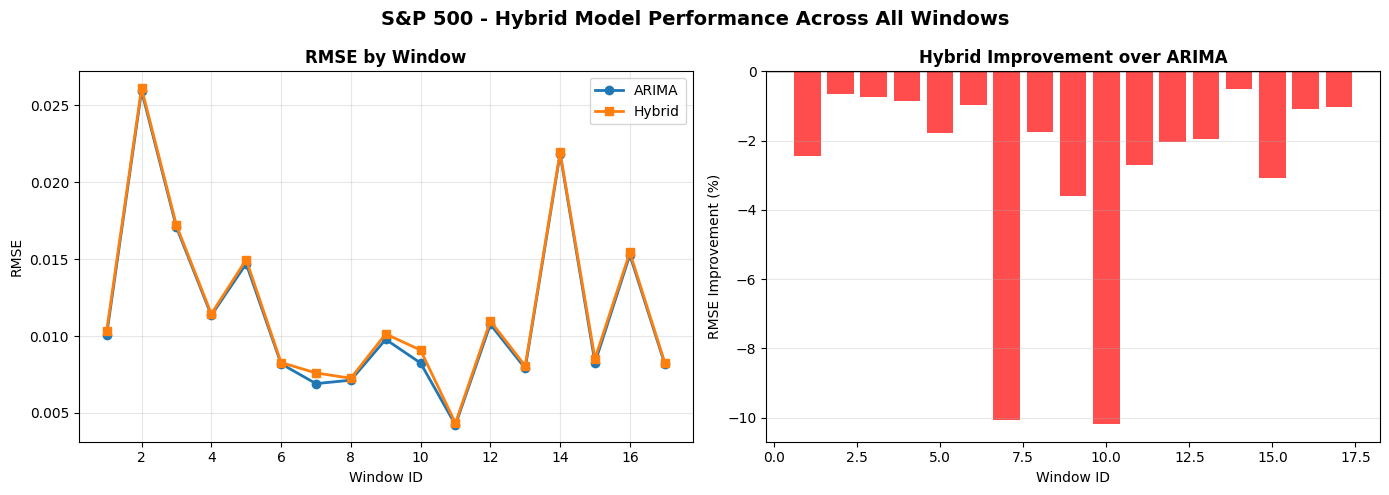


S&P 500 - SUMMARY STATISTICS
Total Windows: 17
Windows where Hybrid outperforms: 0
Windows where ARIMA outperforms: 17
Average Improvement: -2.67%
Best Improvement: -0.51% (Window 14)
Worst Improvement: -10.18% (Window 10)


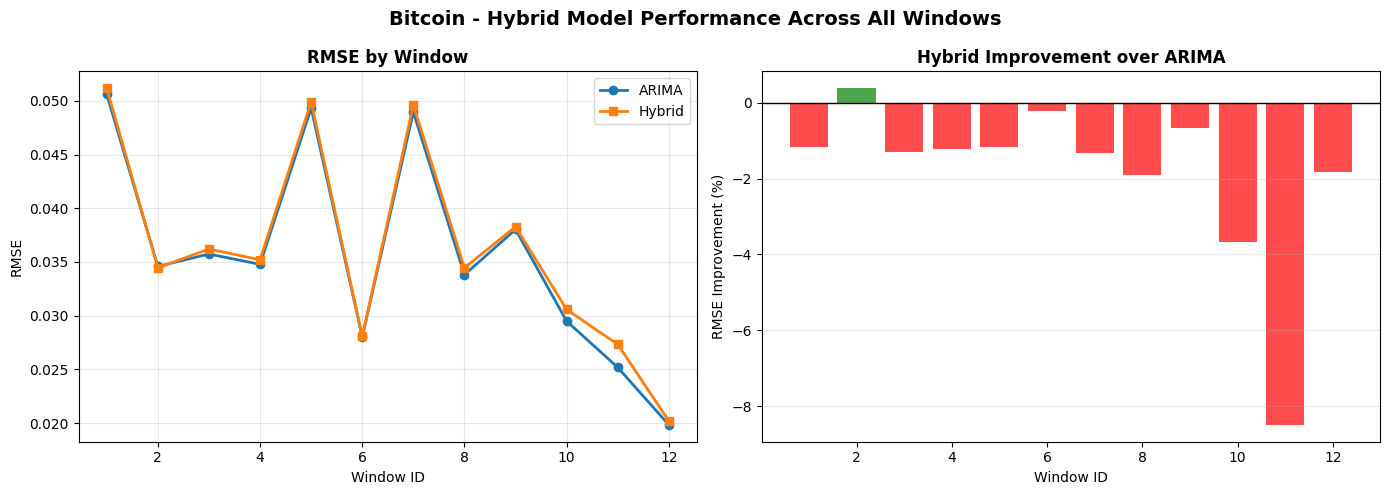


BITCOIN - SUMMARY STATISTICS
Total Windows: 12
Windows where Hybrid outperforms: 1
Windows where ARIMA outperforms: 11
Average Improvement: -1.88%
Best Improvement: 0.38% (Window 2)
Worst Improvement: -8.49% (Window 11)


In [59]:
plot_all_windows_comparison(sp500_hybrid_results)
plot_all_windows_comparison(bitcoin_hybrid_results)

## Evaluation Summary

### Key Metrics Explained:

1. **RMSE (Root Mean Squared Error)**: 
   - Lower is better
   - Penalizes large errors more heavily
   - Measures average magnitude of prediction errors

2. **MAE (Mean Absolute Error)**:
   - Lower is better
   - Average absolute difference between predicted and actual
   - Less sensitive to outliers than RMSE

3. **Directional Accuracy**:
   - Higher is better (max 100%)
   - Percentage of times the model predicted the correct direction (up/down)
   - Very important for trading strategies!

### What to Look For:

✓ **Good Model Signs:**
- Test metrics reasonably close to training metrics (not overfitting)
- Directional accuracy > 50% (better than random)
- Hybrid model outperforms ARIMA-only baseline
- Residuals are randomly distributed (white noise)
- Residuals centered around zero

⚠️ **Warning Signs:**
- Test performance much worse than training (overfitting)
- Directional accuracy < 50% (worse than random guessing)
- Large systematic errors in residuals
- Strong patterns in residual ACF (model missed something)

# EURUSD Dataset Analysis

## ARIMA + LSTM Hybrid
Dataset: EUR/USD Exchange Rate (2009-08-11 to 2019-08-11)

In [60]:
# Download EURUSD data
print("Downloading EURUSD data...")
eurusd_data = yf.download("EURUSD=X", start="2009-08-11", end="2019-08-11", progress=False)

print(f"\nEURUSD Data Shape: {eurusd_data.shape}")
print(f"EURUSD Date Range: {eurusd_data.index.min()} to {eurusd_data.index.max()}")
print(f"Total EURUSD observations: {len(eurusd_data)}")

# Calculate log returns
eurusd_data['Log_Returns'] = np.log(eurusd_data['Close'] / eurusd_data['Close'].shift(1))

# Clean data
eurusd_clean = eurusd_data.dropna()

print(f"\nAfter cleaning: {len(eurusd_clean)} observations")
print(f"Mean daily return: {eurusd_clean['Log_Returns'].mean():.6f}")
print(f"Standard deviation: {eurusd_clean['Log_Returns'].std():.6f}")


EURUSD Data Shape: (2604, 5)
EURUSD Date Range: 2009-08-11 00:00:00 to 2019-08-09 00:00:00
Total EURUSD observations: 2604

After cleaning: 2603 observations
Mean daily return: -0.000090
Standard deviation: 0.005766


In [61]:
# Create cross-validation splits for EURUSD
# Using a simplified approach: 2-year training + 1-year validation (8,16,24 months) + 6-month test
from dateutil.relativedelta import relativedelta
from datetime import timedelta

def create_eurusd_cv_splits(data, start_date=None):
    """
    Create EURUSD cross-validation splits:
    - 2-year training + validation periods + 6-month test
    - Validation periods: 8, 16, 24 months
    - Window shifts forward by 1 year each iteration
    """
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1)
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1)
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check if we have enough data
        if test_end > data.index.max():
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2,
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

# Create EURUSD CV splits
eurusd_cv_splits = create_eurusd_cv_splits(eurusd_clean)

print(f"\n=== EURUSD Cross-Validation Setup ===")
print(f"Total CV windows: {len(eurusd_cv_splits)}")
print(f"\nFirst window details:")
print(f"  Train: {eurusd_cv_splits[0]['train']['start'].date()} to {eurusd_cv_splits[0]['train']['end'].date()} ({eurusd_cv_splits[0]['train']['size']} obs)")
print(f"  Val 1: {eurusd_cv_splits[0]['validation'][0]['start'].date()} to {eurusd_cv_splits[0]['validation'][0]['end'].date()} ({eurusd_cv_splits[0]['validation'][0]['size']} obs)")
print(f"  Test:  {eurusd_cv_splits[0]['test']['start'].date()} to {eurusd_cv_splits[0]['test']['end'].date()} ({eurusd_cv_splits[0]['test']['size']} obs)")


=== EURUSD Cross-Validation Setup ===
Total CV windows: 6

First window details:
  Train: 2009-08-12 to 2011-08-11 (522 obs)
  Val 1: 2011-08-12 to 2012-04-11 (174 obs)
  Test:  2013-08-12 to 2014-02-11 (131 obs)


In [62]:
eurusd_hybrid_results = run_hybrid_arima_lstm_cv(
    cv_splits=eurusd_cv_splits,
    data_clean=eurusd_clean,
    asset_name='EURUSD',
    max_p=3,
    max_d=1,
    max_q=3,
    lookback=60,
    lstm_units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=True
)


🔄 HYBRID ARIMA-LSTM CROSS-VALIDATION: EURUSD
Architecture: ARIMA (linear) + LSTM on residuals (non-linear)
ARIMA space: p∈[0,3], d∈[0,1], q∈[0,3]
LSTM config: lookback=60, units=50, dropout=0.2
Total windows: 6
----------------------------------------------------------------------------------------------------

📊 Window 1/6
   Train: 2009-08-12 to 2011-08-11 (522 obs)
   Test:  2013-08-12 to 2014-02-11 (131 obs)
   [1/4] 📈 Fitting ARIMA model...
       ✓ Best ARIMA(0, 0, 0), AIC=-3681.48
   [2/4] 🔍 Calculating ARIMA residuals...
       ✓ Residuals: mean=0.000005, std=0.007090
   [3/4] 🧠 Training LSTM on residuals...
       ✓ LSTM trained (11 epochs)
   [4/4] 🎯 Generating hybrid forecasts...
   ✅ RESULTS:
       ARIMA only:  RMSE=0.003908,MAE=0.002982, Direction=44.6%
       HYBRID:      RMSE=0.004049,MAE=0.003109, Direction=48.5%
       Improvement: -3.61% RMSE

📊 Window 2/6
   Train: 2010-08-12 to 2012-08-11 (522 obs)
   Test:  2014-08-12 to 2015-02-11 (132 obs)
   [1/4] 📈 Fitting AR

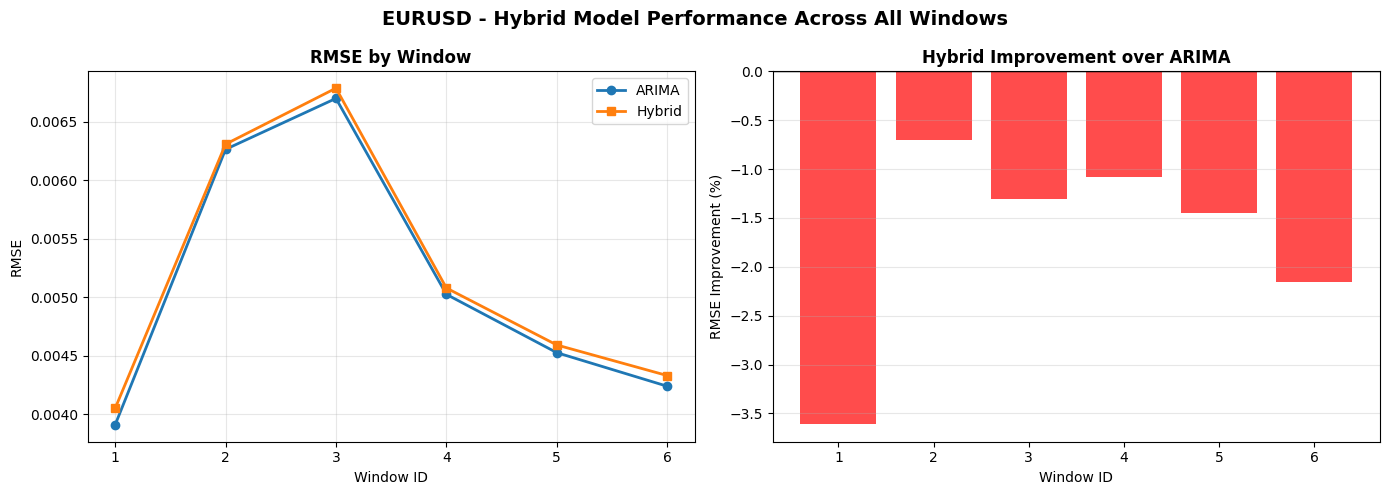


EURUSD - SUMMARY STATISTICS
Total Windows: 6
Windows where Hybrid outperforms: 0
Windows where ARIMA outperforms: 6
Average Improvement: -1.72%
Best Improvement: -0.70% (Window 2)
Worst Improvement: -3.61% (Window 1)


In [63]:
plot_all_windows_comparison(eurusd_hybrid_results)

# Get all predictions

In [ ]:
# def volatility_predictions_to_returns(predictions, true_values, actual_returns):
#     """
#     Convert volatility predictions into trading returns.
    
#     Strategy: Go long when predicted volatility is below median (low risk),
#               go short when predicted volatility is above median (high risk).
    
#     Parameters:
#     -----------
#     predictions : np.array
#         Predicted volatility values
#     true_values : np.array
#         Actual volatility values
#     actual_returns : pd.Series or np.array
#         Actual market returns aligned with predictions
        
#     Returns:
#     --------
#     pd.Series : Strategy returns based on volatility forecasts
#     """
    
#     # Ensure we have the same length
#     min_len = min(len(predictions), len(true_values), len(actual_returns))
#     predictions = predictions[:min_len]
#     true_values = true_values[:min_len]
#     actual_returns = actual_returns[:min_len] if isinstance(actual_returns, np.ndarray) else actual_returns.iloc[:min_len]
    
#     # Calculate prediction median
#     pred_median = np.median(predictions)
    
#     # Trading signal: +1 when low predicted volatility, -1 when high
#     # Rationale: Low volatility → favorable conditions → go long
#     #            High volatility → unfavorable conditions → go short or defensive
#     signals = np.where(predictions < pred_median, 1, -1)
    
#     # Strategy returns = signal * actual_returns
#     strategy_returns = signals * actual_returns
    
#     return pd.Series(strategy_returns)

In [65]:
cost = 0.005

In [83]:
def get_all_predictions(model_results, data_clean, model_type="S&P", window_indices=None):
    """
    Extract and aggregate returns from model cross-validation results.
    FIXED VERSION: Handles different structures for ARIMA vs LSTM/SVM.
    """

    if model_type == "S&P":
        cost = 0.005
    elif model_type == "Bitcoin":
        cost = 0.01
    all_strategy_returns = []

    windows_to_use = model_results['window_results']
    if window_indices is not None:
        windows_to_use = [w for w in windows_to_use if w['window_id'] in window_indices]
    
    for window_result in windows_to_use:
        try:
            # Get test period dates
            # test_start = window_result['test_period'].split(' to ')[0]
            # test_end = window_result['test_period'].split(' to ')[1]
            test_start = window_result['test_start']
            test_end = window_result['test_end']
            
            # Get actual returns during test period
            test_data = data_clean[test_start:test_end]
            
            # Get predictions - handle different model structures
            # evaluation = window_result['evaluation']

            predictions = window_result['hybrid_predictions']
            true_values = test_data['Log_Returns'].values[-len(predictions):]
            
            
            # Align returns with predictions
            actual_returns = test_data['Log_Returns'].iloc[-len(predictions):]
            
            # Generate strategy returns for this window
            window_returns = volatility_predictions_to_returns_new(
                predictions, true_values, actual_returns.values, transaction_costs=cost
            )
            
            all_strategy_returns.append(window_returns)
            
        except Exception as e:
            print(f"⚠️  Warning: Failed to process window {window_result.get('window_id', '?')}: {str(e)}")
            continue
    
    # Concatenate all returns
    if all_strategy_returns:
        return pd.concat(all_strategy_returns, ignore_index=True)
    else:
        return pd.Series([])


In [84]:
# Function to get all predictions

get_all_predictions(sp500_hybrid_results, sp500_clean)
get_all_predictions(bitcoin_hybrid_results, bitcoin_clean)
get_all_predictions(eurusd_hybrid_results, eurusd_clean)


0     -0.000000
1     -0.000000
2     -0.000000
3     -0.000000
4      0.006748
         ...   
781   -0.000000
782   -0.000000
783   -0.000000
784   -0.000000
785   -0.000000
Length: 786, dtype: float64

## Trading Performance Metrics

In [92]:
def volatility_predictions_to_returns_new(predictions, true_values, actual_returns, transaction_costs=0.0):
    """
    Convert volatility predictions into trading returns using -1, 0, 1 long-short signals.
    
    Implements sections 4.5 and 4.6 methodology from the paper.
    
    Strategy:
    - Signal = +1 when predicted volatility < median (low risk, favorable to go LONG)
    - Signal = -1 when predicted volatility > median (high risk, favorable to go SHORT)
    - Signal = 0 when position should be neutral (within transaction cost threshold)
    
    Parameters:
    -----------
    predictions : np.array
        Predicted volatility values from model
    true_values : np.array
        Actual volatility values (for reference)
    actual_returns : pd.Series or np.array
        Actual market returns aligned with predictions
    transaction_costs : float, optional
        Transaction costs in decimal form (e.g., 0.005 = 0.5%)
        Default: 0.0 (no transaction costs)
        
    Returns:
    --------
    pd.Series : Strategy returns based on volatility forecasts with -1, 0, 1 signals
    
    Example:
    --------
    >>> strategy_returns = volatility_predictions_to_returns(
    ...     predictions=volatility_preds,
    ...     true_values=actual_volatility,
    ...     actual_returns=market_returns,
    ...     transaction_costs=0.005
    ... )
    >>> metrics = compute_performance_indicators(strategy_returns, benchmark_returns)
    """
    # Ensure all arrays have matching length
    min_len = min(len(predictions), len(true_values), len(actual_returns))
    predictions = predictions[:min_len]
    true_values = true_values[:min_len]
    actual_returns = (actual_returns.iloc[:min_len] 
                     if isinstance(actual_returns, pd.Series) 
                     else actual_returns[:min_len])
    
    # Convert to numpy arrays for consistency
    actual_returns_array = (actual_returns.values 
                           if isinstance(actual_returns, pd.Series) 
                           else actual_returns)
    
    # Calculate median volatility as threshold
    # pred_median = np.median(predictions)
    
    # === SIGNAL GENERATION: -1, 0, 1 STRUCTURE ===
    # Base signals based on volatility threshold
    # +1: Low volatility (predicted < median) → Favorable for LONG positions
    # -1: High volatility (predicted > median) → Favorable for SHORT positions
    # signal = np.where(predictions < pred_median, 1, -1)
    signal = np.where(predictions > transaction_costs, 1, -1)
    
    # Apply transaction cost filter
    # Only trade if expected return magnitude exceeds transaction costs
    # Otherwise, maintain neutral position (signal = 0)
    if transaction_costs > 0.0:
        signals = np.where(np.abs(actual_returns_array) > transaction_costs, signal, 0)
    
    # === STRATEGY RETURNS ===
    # Returns = Signal × Actual Returns
    # +1 signal: captures full upside (goes long when low vol predicted)
    # -1 signal: captures short side (goes short when high vol predicted)
    # 0 signal: no position, zero return contribution
    strategy_returns = signals * actual_returns_array
    
    return pd.Series(strategy_returns)

In [93]:
def extract_model_returns_from_results_fixed(model_results, data_clean, model_type="S&P", window_indices=None):
    """
    Extract and aggregate returns from model cross-validation results.
    FIXED VERSION: Handles different structures for ARIMA vs LSTM/SVM.
    """
    if model_type == "S&P":
        cost = 0.005
    elif model_type == "Bitcoin":
        cost = 0.065
    all_strategy_returns = []
    
    windows_to_use = model_results['all_results']
    if window_indices is not None:
        windows_to_use = [w for w in windows_to_use if w['window_id'] in window_indices]
    
    for window_result in windows_to_use:
        try:
            # Get test period dates
            test_start = window_result['test_period'].split(' to ')[0]
            test_end = window_result['test_period'].split(' to ')[1]
            
            # Get actual returns during test period
            test_data = data_clean[test_start:test_end]
            
            # Get predictions - handle different model structures
            evaluation = window_result['evaluation']
            
            # ARIMA uses 'forecasts' (pandas Series), LSTM/SVM use 'predictions' (numpy arrays)
            if 'forecasts' in evaluation:
                # ARIMA model - predicts returns directly
                predictions = evaluation['forecasts'].values
                true_values = test_data['Log_Returns'].values[-len(predictions):]
            elif 'predictions' in evaluation:
                # LSTM or SVM model - predicts volatility
                predictions = evaluation['predictions']
                true_values = evaluation['true_values']
            else:
                print(f"⚠️  Warning: Unknown evaluation structure for window {window_result['window_id']}")
                continue
            
            # Align returns with predictions
            actual_returns = test_data['Log_Returns'].iloc[-len(predictions):]
            
            # Generate strategy returns for this window
            # window_returns = volatility_predictions_to_returns(
            #     predictions, true_values, actual_returns.values
            # )
            window_returns = volatility_predictions_to_returns_new(
                predictions, true_values, actual_returns.values, transaction_costs= cost
            )
            
            all_strategy_returns.append(window_returns)
            
        except Exception as e:
            print(f"⚠️  Warning: Failed to process window {window_result.get('window_id', '?')}: {str(e)}")
            continue
    
    # Concatenate all returns
    if all_strategy_returns:
        return pd.concat(all_strategy_returns, ignore_index=True)
    else:
        return pd.Series([])


In [94]:
def annualized_return(daily_returns):
    """ARC: Annualized return from daily returns."""
    cumulative = (1 + daily_returns).prod()
    n = daily_returns.shape[0]
    return cumulative ** (TRADING_DAYS / n) - 1


def annualized_std(daily_returns):
    """ASD: Annualized standard deviation from daily returns."""
    return daily_returns.std() * np.sqrt(TRADING_DAYS)


def max_drawdown(daily_returns):
    """MD: Maximum drawdown from equity curve (Eq 24)."""
    equity = (1 + daily_returns).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return np.abs(drawdown.min())  # Paper uses absolute value


def information_ratio(strategy_returns, benchmark_returns):
    """IR: Information ratio (Paper definition: Eq 25)."""
    # Paper defines IR = ARC / ASD
    # It does NOT use benchmark tracking error
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    
    if asd == 0:
        return np.nan
    return arc / asd


def modified_information_ratio(strategy_returns, benchmark_returns):
    """IR*: Adjusted Information Ratio (Paper definition: Eq 26)."""
    # Paper defines IR* = (ARC^2 * sign(ARC)) / (ASD * MD)
    # Simplified: IR * (ARC / MD)
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    md = max_drawdown(strategy_returns)
    
    if asd == 0 or md == 0:
        return np.nan
        
    return (arc * np.sign(arc) * arc) / (asd * md)


def sortino_ratio(daily_returns, risk_free_rate=0):
    """SR: Sortino Ratio (Paper definition: Eq 27)."""
    # Paper defines SR = ARC / Downside Deviation
    # Paper does NOT subtract risk_free_rate from ARC
    
    # Identify negative returns
    negative_returns = daily_returns[daily_returns < 0]
    
    if len(negative_returns) == 0:
        return np.nan
        
    # Calculate downside deviation (annualized)
    downside_std = np.std(negative_returns, ddof=1)
    asd_downside = downside_std * np.sqrt(TRADING_DAYS)
    
    arc = annualized_return(daily_returns)
    
    if asd_downside == 0:
        return np.nan
        
    return arc / asd_downside


def compute_performance_indicators(strategy_returns, benchmark_returns):
    """Compute all 6 metrics at once."""
    return {
        "ARC": annualized_return(strategy_returns),
        "ASD": annualized_std(strategy_returns),
        "MD": abs(max_drawdown(strategy_returns)),
        "IR": information_ratio(strategy_returns, benchmark_returns),
        "IR*": modified_information_ratio(strategy_returns, benchmark_returns),
        "SR": sortino_ratio(strategy_returns)
    }


print("✓ Metric functions defined (ARC, ASD, MD, IR, IR*, SR)")

✓ Metric functions defined (ARC, ASD, MD, IR, IR*, SR)


## S&P 500

In [ ]:
# S&P 500 Evaluation - APPROACH A
TRADING_DAYS = 232
print("\n" + "="*80)
print("EVALUATING S&P 500 LONG-SHORT STRATEGY")
print("="*80)

# Get benchmark returns (Buy-and-Hold)
sp500_bnh_returns = sp500_clean['Log_Returns'].loc["2007-01-01":"2023-12-29"].values

print(f"\n✓ Buy-and-Hold baseline: {len(sp500_bnh_returns)} days")

# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

sp500_hybrid_predictions = get_all_predictions(sp500_hybrid_results, sp500_clean)

sp500_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    sp500_hybrid_predictions, sp500_bnh_returns, sp500_bnh_returns, transaction_costs=0.005
    )
sp500_bnh_aligned = sp500_bnh_returns[-len(sp500_hybrid_strategy_returns):]


print("\nComputing performance metrics...")
results_sp500 = []

# HYBRID
hybrid_metrics = compute_performance_indicators(
    pd.Series(sp500_hybrid_strategy_returns),
    pd.Series(sp500_bnh_aligned)
)
hybrid_metrics['Model'] = 'HYBRID'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_hybrid_strategy_returns > 0)) > 0))
results_sp500.append(hybrid_metrics)


# Create TABLE 2
print("\nGenerating Table 2...")
table2_sp500 = pd.DataFrame(results_sp500)

print("\n" + "="*90)
print("TABLE 2: S&P 500 Long-Short Strategy Results")
print("="*90)
print(table2_sp500[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_sp500.to_csv('table2_sp500.csv', index=False)
print("\n✓ Results saved to 'table2_sp500.csv'")

best_idx = table2_sp500['IR'].idxmax()
print(f"\n✓ Best Model: {table2_sp500.loc[best_idx, 'Model']} (IR = {table2_sp500.loc[best_idx, 'IR']:.4f})")



EVALUATING S&P 500 LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 4278 days

Extracting strategy returns from each model...

Computing performance metrics...

Generating Table 2...

TABLE 2: S&P 500 Long-Short Strategy Results
 Model       ARC      ASD  MD        IR       IR*        SR
HYBRID -0.810567 0.159981 1.0 -5.066658 -4.106864 -4.859825

✓ Results saved to 'table2_sp500.csv'

✓ Best Model: HYBRID (IR = -5.0667)


## Bitcoin

In [112]:
# BITCOIN Evaluation - APPROACH A

print("\n" + "="*80)
print("EVALUATING BITCOIN LONG-SHORT STRATEGY")
print("="*80)

TRADING_DAYS = 345

# Get benchmark returns (Buy-and-Hold)
bitcoin_bnh_returns = bitcoin_clean['Log_Returns'].values


print(f"\n✓ Buy-and-Hold baseline: {len(bitcoin_bnh_returns)} days")

# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

bitcoin_hybrid_predictions = get_all_predictions(bitcoin_hybrid_results, bitcoin_clean)

bitcoin_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    bitcoin_hybrid_predictions, bitcoin_bnh_returns, bitcoin_bnh_returns, transaction_costs=0.0065
    )
bitcoin_bnh_aligned = bitcoin_bnh_returns[-len(bitcoin_hybrid_strategy_returns):]


# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_bitcoin = []

# HYBRID
hybrid_metrics = compute_performance_indicators(
    pd.Series(bitcoin_hybrid_strategy_returns),
    pd.Series(bitcoin_bnh_aligned)
)
hybrid_metrics['Model'] = 'HYBRID'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_hybrid_strategy_returns > 0)) > 0))
results_bitcoin.append(hybrid_metrics)

# Create TABLE 2
print("\nGenerating Table 2...")
table2_bitcoin = pd.DataFrame(results_bitcoin)

print("\n" + "="*90)
print("TABLE 2: Bitcoin Long-Short Strategy Results")
print("="*90)
print(table2_bitcoin[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_bitcoin.to_csv('table2_bitcoin.csv', index=False)
print("\n✓ Results saved to 'table2_bitcoin.csv'")

best_idx = table2_bitcoin['IR'].idxmax()
print(f"\n✓ Best Model: {table2_bitcoin.loc[best_idx, 'Model']} (IR = {table2_bitcoin.loc[best_idx, 'IR']:.4f})")



EVALUATING BITCOIN LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 3285 days

Extracting strategy returns from each model...

Computing performance metrics...

Generating Table 2...

TABLE 2: Bitcoin Long-Short Strategy Results
 Model       ARC      ASD       MD        IR       IR*        SR
HYBRID -0.523806 0.725488 0.996544 -0.722006 -0.379503 -0.956083

✓ Results saved to 'table2_bitcoin.csv'

✓ Best Model: HYBRID (IR = -0.7220)


## EURUSD

In [113]:
# EURUSD Evaluation - APPROACH A

print("\n" + "="*80)
print("EVALUATING EURUSD LONG-SHORT STRATEGY")
print("="*80)

TRADING_DAYS = 345

# Get benchmark returns (Buy-and-Hold)
eurusd_bnh_returns = eurusd_clean['Log_Returns'].values


print(f"\n✓ Buy-and-Hold baseline: {len(eurusd_bnh_returns)} days")

# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

eurusd_hybrid_predictions = get_all_predictions(eurusd_hybrid_results, eurusd_clean)

eurusd_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    eurusd_hybrid_predictions, eurusd_bnh_returns, eurusd_bnh_returns, transaction_costs=0.0065
    )
eurusd_bnh_aligned = eurusd_bnh_returns[-len(eurusd_hybrid_strategy_returns):]


# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_eurusd = []

# HYBRID
hybrid_metrics = compute_performance_indicators(
    pd.Series(eurusd_hybrid_strategy_returns),
    pd.Series(eurusd_bnh_aligned)
)
hybrid_metrics['Model'] = 'HYBRID'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_hybrid_strategy_returns > 0)) > 0))
results_eurusd.append(hybrid_metrics)

# Create TABLE 2
print("\nGenerating Table 2...")
table2_eurusd = pd.DataFrame(results_eurusd)

print("\n" + "="*90)
print("TABLE 2: EURUSD Long-Short Strategy Results")
print("="*90)
print(table2_eurusd[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_eurusd.to_csv('table2_eurusd.csv', index=False)
print("\n✓ Results saved to 'table2_eurusd.csv'")

best_idx = table2_eurusd['IR'].idxmax()
print(f"\n✓ Best Model: {table2_eurusd.loc[best_idx, 'Model']} (IR = {table2_eurusd.loc[best_idx, 'IR']:.4f})")



EVALUATING EURUSD LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 2603 days

Extracting strategy returns from each model...

Computing performance metrics...

Generating Table 2...

TABLE 2: EURUSD Long-Short Strategy Results
 Model      ARC      ASD       MD       IR      IR*       SR
HYBRID 0.014358 0.118998 0.230914 0.120661 0.007503 0.231965

✓ Results saved to 'table2_eurusd.csv'

✓ Best Model: HYBRID (IR = 0.1207)
